# Сегментация пользователей интернет-магазина

## Материалы
1. Презентация - https://drive.google.com/file/d/1_ZtgyiOV0rb-HPZQa9nWrcw3CqgU0hF3/view?usp=sharing
2. Дашборд - https://public.tableau.com/app/profile/dmitry4808/viz/_16315429727090/sheet2?publish=yes

## Общие положения

**Заказчик** — отдел маркетинга / продаж

**Задача исследования** -  провести сегментацию покупателей магазина на основе их профиля потребления для разработки персонализированных предложений

**Гипотеза:**
- Структура потребления пользователей по продуктам влияет на их средний чек
- Структура потребления пользователей по продуктам влияет на их частоту заказов


**Исходные данные** — датасет с транзакциями интернет-магазина товаров


**Основные шаги:**

- Загрузка и общий обзор данных
- Предобработка данных
- Исследовательский анализ
- Кластеризация пользователей на основе микса их потребления по продуктам
- Проверить различия в среднем чеке и частоте заказов между сегментами потребителей
- Сформулировать выводы и рекомендации
- Подготовить презентацию

## Загрузка данных

In [1]:
#импорт библиотек
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from io import BytesIO
import requests
import scipy.stats as stats
from pymystem3 import Mystem
m = Mystem() 
from collections import Counter
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
#чтение файлов из внешнего источника, либо с рабочего стола
try:
    spreadsheet_id =  '1C1uIArALG9xUdJyyvDDwKLLMJiW13P6HWuBJ_rtz7iM'
    file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
    r = requests.get(file_name)
    df = pd.read_csv(BytesIO(r.content))
except:
    path = "C:/Users/au31894/OneDrive - Alliance/Рабочий стол/Программирование/Исходные данные/"
    df = pd.read_csv(path + "ecommerce_dataset.csv")
    
display(df.head(5))
display(df.info())

date                           customer_id  order_id  \
0  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  2018100100  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0  
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0  
2                        Радермахера d-12 см h-20 см         1  112.0  
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0  
4                     Циперус Зумула d-12 см h-25 см         1  112.0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 6 columns):
date           6737 non-null int64
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
dtypes: float64(1), int64(3), object(2)
memory usage: 315.9+ KB


None

## Предобработка данных

#### Комментарий
- Пропуски не обнаружены
- Даты в некорректном формате, в дате сначала идет год, затем месяц, число и час

In [3]:
# перевод дат в формат даты и времени
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d%H')
# почасовой анализ для сегментации избыточен, поэтому введем доп.признак, где будет только дата
df['date_only'] = df['date'].dt.date
df['date_only'] = pd.to_datetime(df['date_only'], format='%Y-%m-%d')
df['month'] = df['date_only'].dt.to_period('M')
df['month'] = df['month'].astype('str')
df.head()

date                           customer_id  order_id  \
0 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4 2018-10-01  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  \
0    Комнатное растение в горшке Алое Вера, d12, h30         1  142.0   
1  Комнатное растение в горшке Кофе Арабика, d12,...         1  194.0   
2                        Радермахера d-12 см h-20 см         1  112.0   
3                   Хризолидокарпус Лутесценс d-9 см         1  179.0   
4                     Циперус Зумула d-12 см h-25 см         1  112.0   

   date_only    month  
0 2018-10-01  2018-10  
1 2018-10-01  2018-10  
2 2018-10-01  2018-10  
3 2018-10-01  2018-10  
4 2018-10-01  2018-10

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6737 entries, 0 to 6736
Data columns (total 8 columns):
date           6737 non-null datetime64[ns]
customer_id    6737 non-null object
order_id       6737 non-null int64
product        6737 non-null object
quantity       6737 non-null int64
price          6737 non-null float64
date_only      6737 non-null datetime64[ns]
month          6737 non-null object
dtypes: datetime64[ns](2), float64(1), int64(2), object(3)
memory usage: 421.2+ KB


In [5]:
# посмотрим начало и конец периода
display(df['date_only'].min(), df['date_only'].max())

Timestamp('2018-10-01 00:00:00')

Timestamp('2019-10-31 00:00:00')

#### Комментарий
Данные даны с 1 октября 2018 года по 31 октября 2019 года, т.е. практически год

In [6]:
# приведеним к нижнему регистру значения в столбце product
df['product'] = df['product'].str.lower()
# проверка на полные дубликаты
print('Дубликаты в базе объектов:', df.duplicated().sum())
df.tail()

Дубликаты в базе объектов: 0


date                           customer_id  order_id  \
6732 2019-10-31 11:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73156   
6733 2019-10-31 12:00:00  1f0a7f35-7459-4f23-b468-5e45bf481dd1     73158   
6734 2019-10-31 13:00:00  25df96a7-c453-4708-9cea-a3dfc7c342ea     73162   
6735 2019-10-31 14:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73164   
6736 2019-10-31 16:00:00  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                product  quantity   price  \
6732  таз пластмассовый 40,0 л пищевой овальный (иж)...         1   404.0   
6733         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   
6734  герань домашняя (пеларгония зональная) цветуща...         1   157.0   
6735  таз пластмассовый со стиральной доской (иж), 1...         1   397.0   
6736         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   

      date_only    month  
6732 2019-10-31  2019-10  
6733 2019-10-31  2019-10  
6734 2019-10-31  2019-10  
6735 2019-10-31  2019-10  
6736 2019-10-31  2019-10

#### Комментарий
Полные дубликаты не обнаружены

In [7]:
# уберем дату с часами и проверим дубликаты еще раз
df_without_hours = df.drop(df.columns[[0]], axis = 1)
print('Дубликаты в базе объектов:', df.duplicated().sum())
df.tail()

Дубликаты в базе объектов: 0


date                           customer_id  order_id  \
6732 2019-10-31 11:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73156   
6733 2019-10-31 12:00:00  1f0a7f35-7459-4f23-b468-5e45bf481dd1     73158   
6734 2019-10-31 13:00:00  25df96a7-c453-4708-9cea-a3dfc7c342ea     73162   
6735 2019-10-31 14:00:00  73d1cd35-5e5f-4629-8cf2-3fda829d4e58     73164   
6736 2019-10-31 16:00:00  344aa778-e436-419e-a9c6-9b8f37b7c1df     73137   

                                                product  quantity   price  \
6732  таз пластмассовый 40,0 л пищевой овальный (иж)...         1   404.0   
6733         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   
6734  герань домашняя (пеларгония зональная) цветуща...         1   157.0   
6735  таз пластмассовый со стиральной доской (иж), 1...         1   397.0   
6736         сумка-тележка 2-х колесная gimi argo синяя         1  1087.0   

      date_only    month  
6732 2019-10-31  2019-10  
6733 2019-10-31  2019-10  
6734 2019-10-31  2019-10  
6735 2019-10-31  2019-10  
6736 2019-10-31  2019-10

##### Комментарий
Но по датам без часов таких дубликатов строк 966 штук, а это 14% датасета.
Таким образом есть клиенты, которые имеют абсолютно аналогичные строки в заказе за исключением часа заказа.
Скорее всего это техническая аномалия, т.к. покупка одного и того же товара с разницей во времени в том же кол-ве нехарактерное поведение покупателя.
Целесообразно удалить эти значения.


In [8]:
df = df_without_hours.drop_duplicates().reset_index(drop= True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5771 entries, 0 to 5770
Data columns (total 7 columns):
customer_id    5771 non-null object
order_id       5771 non-null int64
product        5771 non-null object
quantity       5771 non-null int64
price          5771 non-null float64
date_only      5771 non-null datetime64[ns]
month          5771 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 315.7+ KB


In [9]:
# уберем даты вообще и посмотрим, есть ли полные дубликаты в рамках одного заказа, независимо от дат
print('Дубликаты в базе объектов:', df.duplicated(subset=['customer_id', 'order_id', 'product', 'quantity', 'price']).sum())
df = df.drop_duplicates(subset=['customer_id', 'order_id', 'product', 'quantity', 'price'])
df.info()

Дубликаты в базе объектов: 898
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4873 entries, 0 to 5769
Data columns (total 7 columns):
customer_id    4873 non-null object
order_id       4873 non-null int64
product        4873 non-null object
quantity       4873 non-null int64
price          4873 non-null float64
date_only      4873 non-null datetime64[ns]
month          4873 non-null object
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 304.6+ KB


#### Комментарий
Кроме того, обнаружены полные дубликаты внутри заказов, отличающиеся только датами. Принято решение также их удалить, т.к. дублирование строк внутри заказа разными датами - это скорее техническая особенность учета заказов, но для анализа такие дубли искажают картину. Необходимо указать на это дата-инженерам.

In [10]:
# добавим выручку в исходный датафрейм
df['revenue'] = df['price'] * df['quantity']

### Вывод

Таким образом, из общего датасета были удалены 1312 строк - 23% данных по транзакциям как дубликаты

## Общий обзор данных

In [11]:
#просмотр уникальных значений
def unique_function(data):
    for col in data:
        print('Уникальные значения:', col)
        display(data[col].value_counts())

print('База транзакций пользователей')
unique_function(df)

База транзакций пользователей
Уникальные значения: customer_id


c971fb21-d54c-4134-938f-16b62ee86d3b    143
d3b9ffea-d143-4747-8d59-74ab843d1ad6     51
4d93d3f6-8b24-403b-a74b-f5173e40d7db     45
760aa067-90c3-4794-b7a9-a8831197388b     36
2a0acc09-e343-4f92-b5c0-f598ef2b07d4     31
                                       ... 
d109eb8f-0193-43fa-8a59-cffdb258db32      1
4a856a9b-4128-4a2c-8f56-df9c1e937ed2      1
8d79f722-c1e6-4804-999b-a06c3fbf9c77      1
e388d4cc-397a-4647-a936-82d3bd7e30a6      1
882dfc1f-291a-47bd-9302-05a836e7e6ff      1
Name: customer_id, Length: 2451, dtype: int64

Уникальные значения: order_id


14698    51
14715    36
14688    31
14753    30
14705    29
         ..
72805     1
68707     1
72801     1
68703     1
69638     1
Name: order_id, Length: 2784, dtype: int64

Уникальные значения: product


пеларгония розебудная red pandora укорененный черенок                                          66
пеларгония розебудная prins nikolai укорененный черенок                                        57
пеларгония зональная диам. 12 см сиреневый полумахровый                                        52
сумка-тележка 2-х колесная gimi argo синяя                                                     47
пеларгония розебудная mary укорененный черенок                                                 39
                                                                                               ..
ополаскиватель для посудомоечных машин ludwik 750 мл польша 5900861242715                       1
роза садовая парковая в горшке августа луиза                                                    1
кореопсис толл 0,1 г 4650091480258                                                              1
скатерть рим 88% полиэфир 12% хлопок прямоугольная 350х150 см голубая wellness mc355-рим*16     1
штора для ванной ком

Уникальные значения: quantity


1       3812
2        443
3        140
4        101
10        72
5         67
6         42
15        23
7         22
30        17
25        16
20        16
8         14
12        13
50         8
9          7
40         6
13         5
11         5
100        4
16         4
24         3
150        3
14         2
64         2
27         2
60         2
96         1
140        1
200        1
80         1
300        1
1000       1
59         1
17         1
29         1
37         1
43         1
57         1
65         1
18         1
22         1
26         1
70         1
170        1
334        1
23         1
31         1
45         1
Name: quantity, dtype: int64

Уникальные значения: price


38.0       257
120.0      217
135.0      212
188.0      190
150.0      184
          ... 
6307.0       1
4724.0       1
14917.0      1
3089.0       1
4117.0       1
Name: price, Length: 360, dtype: int64

Уникальные значения: date_only


2019-04-24    85
2019-05-13    83
2019-05-14    58
2019-05-12    54
2019-04-27    53
              ..
2019-01-02     1
2019-06-23     1
2019-01-04     1
2019-09-02     1
2019-05-06     1
Name: date_only, Length: 391, dtype: int64

Уникальные значения: month


2019-05    737
2019-04    677
2018-10    484
2018-11    428
2019-03    418
2019-02    363
2018-12    318
2019-07    313
2019-06    307
2019-09    221
2019-10    219
2019-08    202
2019-01    186
Name: month, dtype: int64

Уникальные значения: revenue


120.0     199
135.0     185
188.0     170
150.0     166
38.0      136
         ... 
7597.0      1
2926.0      1
3600.0      1
1640.0      1
4117.0      1
Name: revenue, Length: 651, dtype: int64

#### Комментарий
- Товаров много - без их категоризации не обойтись
- Есть крупные заказы огромным кол-вом позиций

## Исследовательский анализ данных

### Анализ магазина в целом

In [12]:
# функция сводной
def pivot_func(data, index, value, aggfunc):
    data = data.pivot_table(index= index, values= value, aggfunc=[aggfunc])
    data.columns = data.columns.get_level_values(1)
    data = data.sort_values(by = value, ascending = False)
    return data

In [13]:
# подсчитаем общую выручку магазина
df_total_revenue = df['revenue'].sum()
print('Выручка магазина:',df_total_revenue)

Выручка магазина: 4142154.0


In [14]:
# посмотрим динамику оборота магазина по месяцам
month_TO_pivot = df.pivot_table(index= 'month', values= 'revenue', aggfunc=['sum']).reset_index()
month_TO_pivot.columns = month_TO_pivot.columns.get_level_values(1)
month_TO_pivot.columns = ['month', 'revenue']
display(month_TO_pivot)

month   revenue
0   2018-10  351910.0
1   2018-11  359348.0
2   2018-12  357044.0
3   2019-01  235671.0
4   2019-02  308055.0
5   2019-03  256348.0
6   2019-04  318171.0
7   2019-05  242375.0
8   2019-06  906270.0
9   2019-07  235410.0
10  2019-08  172443.0
11  2019-09  181082.0
12  2019-10  218027.0

In [15]:
fig = px.bar(month_TO_pivot, 
             x = 'month',
             y = 'revenue',
             title = 'Динамика оборота по месяцам', 
             width=800, 
             height=400)
fig.show()

#### Комментарий
- Общая выручка магазина составила около 4.1 млн. руб
- В июне есть аномальный всплеск
- В остальные месяцы оборот сравнительно стабилен

### Анализ клиентов

#### Частота заказов по клиентам


In [16]:
print('Кол-во уникальных клиентов:', df['customer_id'].value_counts().count())

print('Кол-во уникальных заказов:', df['order_id'].value_counts().count())

Кол-во уникальных клиентов: 2451
Кол-во уникальных заказов: 2784


#### Комментарии
Кол-во уникальных заказов немногим больше кол-ва клиентов --> по всей видимости преобладают в основном единичные заказы

In [17]:
# напишем функцию группировки
def grouping_func(data, column_index, column_value, func):
    data = data.groupby([column_index])[column_value].agg({column_value: func}).sort_values(by = column_value, ascending = False).reset_index()
    return data
# сгруппируем пользователей по кол-ву уникальных заказов
orders_qty_by_users = grouping_func(df, 'customer_id', 'order_id', 'nunique')
orders_qty_by_users.columns = ['customer_id', 'order_qty']

In [18]:
# функция построения гистограмм
def hist_maker(column, bins, range_min, range_max):
    print(column.describe())
    plt.figure(figsize=(10,6))
    plt.hist(column, bins=bins, color='grey', edgecolor='grey', alpha=0.8, range = (range_min,range_max))
    plt.axvline(column.describe()['mean'], color='r', linestyle='dashed', linewidth=3, label='Mean value: {:.2f}'.format(column.describe()['mean']))
    plt.axvline(column.describe()['50%'], color='b', linestyle='dotted', linewidth=3, label='Median value: {:.0f}'.format(column.describe()['50%']))
    plt.legend()
    plt.title('Histogramm {}'.format(column.name))

customer_id    160
order_qty      160
dtype: int64

customer_id    0.065279
order_qty      0.065279
dtype: float64

count    2451.000000
mean        1.149327
std         2.655249
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       126.000000
Name: order_qty, dtype: float64


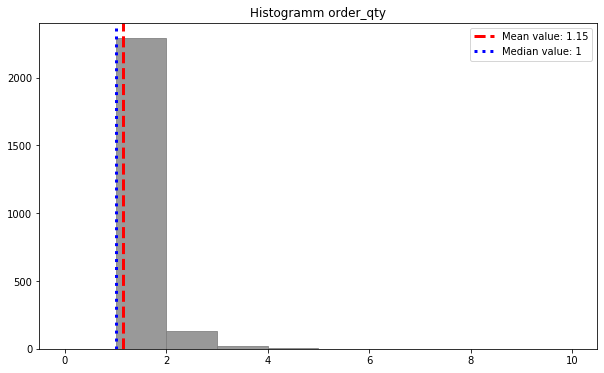

In [19]:
# строим гистограмму распределения по кол-ву уникальных заказов на клиента
display(orders_qty_by_users[orders_qty_by_users['order_qty'] > 1].count())
display(orders_qty_by_users[orders_qty_by_users['order_qty'] > 1].count() / orders_qty_by_users['order_qty'].count())
hist_maker(orders_qty_by_users['order_qty'], 10, 0, 10)

count    2451.000000
mean        1.149327
std         2.655249
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       126.000000
Name: order_qty, dtype: float64


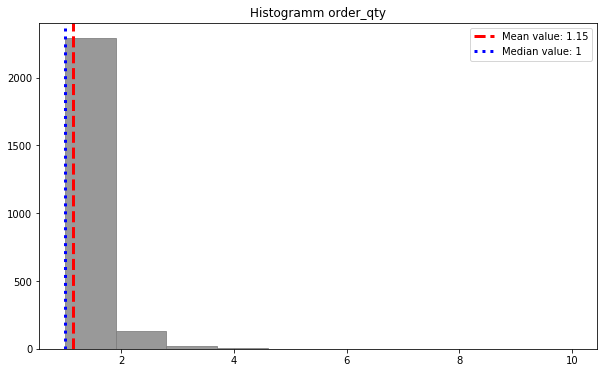

In [20]:
hist_maker(orders_qty_by_users['order_qty'], 10, 1, 10)

In [21]:
# считаем 95 и 99 перцентили
#пропишем функцию
def percentile(df, df_column):
    print('Значения 95 и 99 перцентиля:', np.percentile(df[df_column], [95, 99])) 
    percentile_95 = np.percentile(df[df_column], [95])
    percentile_95 = percentile_95.astype('int').tolist()
    percentile_95 = percentile_95[0]
    print('Значение 95 перцентиля:', percentile_95)
    
def percentile_99_var(df, df_column):
    percentile_99 = np.percentile(df[df_column], [99])
    percentile_99 = percentile_99.astype('int').tolist()
    percentile_99 = percentile_99[0]
    return percentile_99

def percentile_95_var(df, df_column):
    percentile_95 = np.percentile(df[df_column], [95])
    percentile_95 = percentile_95.astype('int').tolist()
    percentile_95 = percentile_95[0]
    return percentile_95

percentile(orders_qty_by_users, 'order_qty')

Значения 95 и 99 перцентиля: [2. 3.]
Значение 95 перцентиля: 2


In [22]:
# посмотрим клиентов с кол-вом заказов > 3
display(orders_qty_by_users[orders_qty_by_users['order_qty'] > 1].count())

customer_id    160
order_qty      160
dtype: int64

#### Комментарии
У 95% клиентов кол-во заказов не больше 2х
Доля клиентов с повторными заказами в течение года составляет всего 6,5% (160 из 2451), т.е. остальные 93% клиентов совершили 1 заказ в год и не вернулись --> retention проверять смысла нет.

#### Выручка и средний чек по клиентам

In [23]:
# посчитаем суммарную выручку в разрезе клиентов
avr_check_by_users = grouping_func(df, 'customer_id', 'revenue', 'sum')
# подтянем кол-ва уникальных заказов и рассчитаем средний чек
avr_check_by_users = avr_check_by_users.merge(orders_qty_by_users, on = 'customer_id', how = 'left')
avr_check_by_users['avr_check'] = avr_check_by_users['revenue'] / avr_check_by_users['order_qty']
avr_check_by_users = avr_check_by_users.sort_values(by = 'avr_check', ascending = False)
avr_check_by_users.head()

customer_id   revenue  order_qty  avr_check
0  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6  675000.0          1   675000.0
4  146cd9bf-a95c-4afb-915b-5f6684b17444   49432.0          1    49432.0
6  8fba3604-ef57-4b9f-b2fe-3402fa8825c8   33680.0          1    33680.0
7  6987e6d6-a63a-4ce2-a2d0-f424092d235e   32718.0          1    32718.0
3  58a4c3cc-504f-43ea-a74a-bae19e665552   53232.0          2    26616.0

count      2451.000000
mean       1500.315703
std       13777.580052
min          14.000000
25%         293.250000
50%         674.000000
75%        1452.000000
max      675000.000000
Name: avr_check, dtype: float64
count      2451.000000
mean       1689.985312
std       14255.913415
min          14.000000
25%         299.000000
50%         712.000000
75%        1574.000000
max      675000.000000
Name: revenue, dtype: float64


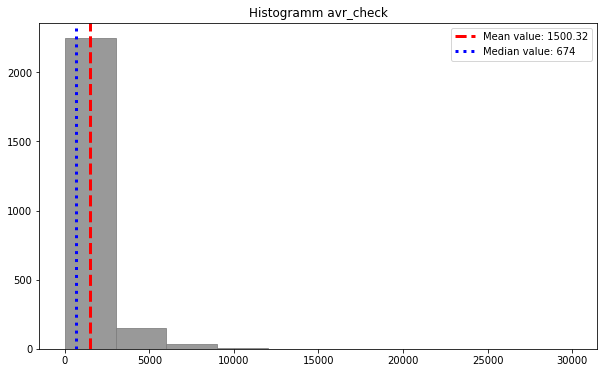

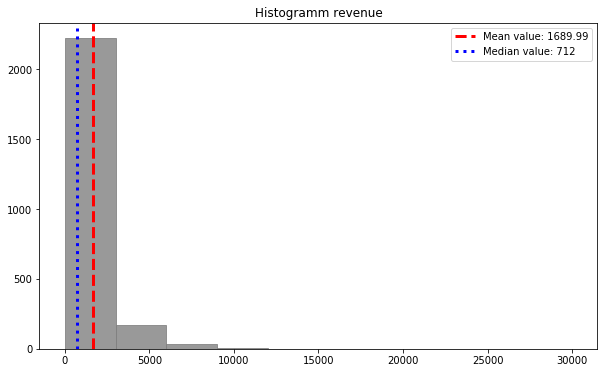

In [24]:
# строим гистограмму распределения по среднему чеку и по выручке
hist_maker(avr_check_by_users['avr_check'], 10, 0, 30000)
hist_maker(avr_check_by_users['revenue'], 10, 0, 30000)

#### Комментарии
Параметры выручки и среднего чека очень похожи, т.к. подавляющее большинство заказов единичные.

Для анализа дальше возмьем средний чек, т.к. она усредняет клиентов и позволяет лучше сравнить клиентов с высокой частотой заказов и клиентов с единичными заказами.

In [25]:
# считаем 95 и 99 перцентили
print('Средний чек')
print(percentile(avr_check_by_users, 'avr_check'))
print('Сумма заказов')
print(percentile(avr_check_by_users, 'revenue'))

Средний чек
Значения 95 и 99 перцентиля: [3947.5 7797. ]
Значение 95 перцентиля: 3947
None
Сумма заказов
Значения 95 и 99 перцентиля: [4174. 8784.]
Значение 95 перцентиля: 4174
None


In [26]:
# посмотрим клиентов с со средним чеком > 7797
display(avr_check_by_users[avr_check_by_users['avr_check'] > 7797].count())

customer_id    25
revenue        25
order_qty      25
avr_check      25
dtype: int64

#### Комментарий
99% клиентов имеют средний чек не больше 7797 руб и генерируют выручку не больше 8784 руб.
Медианный средний чек 734 руб.

Есть и выбросы, например, клиент со средним чеком и выручкой в 675 тыс. руб. 

#### Кол-во купленных уникальных позиций по клиентам

In [27]:
# подсчитаем кол-во уникальных товаров по клиентам в год
products_qty_by_users = grouping_func(df, 'customer_id', 'product', 'nunique')

count    2451.000000
mean        1.932273
std         4.173031
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       130.000000
Name: product, dtype: float64


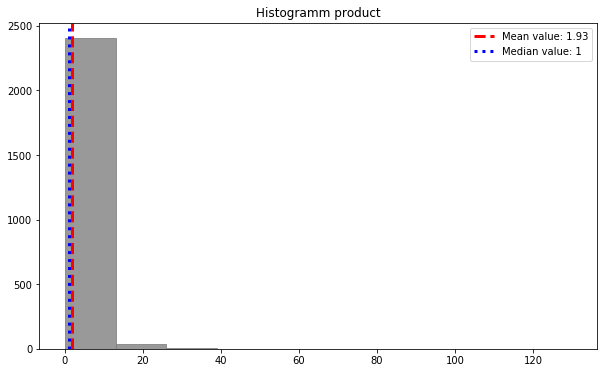

In [28]:
# построим гистограмму распределения по кол-ву позиций купленных за год
hist_maker(products_qty_by_users['product'], 10, 0, 130)

In [29]:
# считаем 95 и 99 перцентили
percentile(products_qty_by_users, 'product')
# проверим у какого % пользователей кол-во уникальных позиций > 1
display('Кол-во пользователей, которые купили больше 1 позиции:', orders_qty_by_users[products_qty_by_users['product'] > 1].count())
display('% пользователей которые купили больше 1 позиции:', orders_qty_by_users[products_qty_by_users['product'] > 1].count() / products_qty_by_users['product'].count())

Значения 95 и 99 перцентиля: [ 7. 18.]
Значение 95 перцентиля: 7


'Кол-во пользователей, которые купили больше 1 позиции:'

customer_id    437
order_qty      437
dtype: int64

'% пользователей которые купили больше 1 позиции:'

customer_id    0.178295
order_qty      0.178295
dtype: float64

#### Комментарий
Только 18% пользователей купили больше 1 позиции из ассортимента магазина в год

#### Cреднее кол-во купленных товаров в заказе клиента

In [30]:
#считаем среднее кол-во позиций в заказе по клиентам
#products_qty_by_users = grouping_func(df, 'customer_id', ['order_id,''product'], 'nunique')
avg_positions_qty_by_users = df.groupby('customer_id').agg({'order_id':'nunique', 'product': 'nunique'}).reset_index()
avg_positions_qty_by_users['avr_positions'] = avg_positions_qty_by_users['product'] / avg_positions_qty_by_users['order_id']
avg_positions_qty_by_users = avg_positions_qty_by_users.sort_values(by = 'avr_positions', ascending = False)
avg_positions_qty_by_users.head()

customer_id  order_id  product  avr_positions
2023  d3b9ffea-d143-4747-8d59-74ab843d1ad6         1       51           51.0
1118  760aa067-90c3-4794-b7a9-a8831197388b         1       36           36.0
392   2a0acc09-e343-4f92-b5c0-f598ef2b07d4         1       31           31.0
591   3d5fef90-4a65-4a7e-84cf-010eba7b038d         1       30           30.0
912   603e92a4-fc7f-4203-9ca5-103da5b008ac         1       29           29.0

count    2451.000000
mean        1.716419
std         2.858087
min         0.333333
25%         1.000000
50%         1.000000
75%         1.000000
max        51.000000
Name: avr_positions, dtype: float64


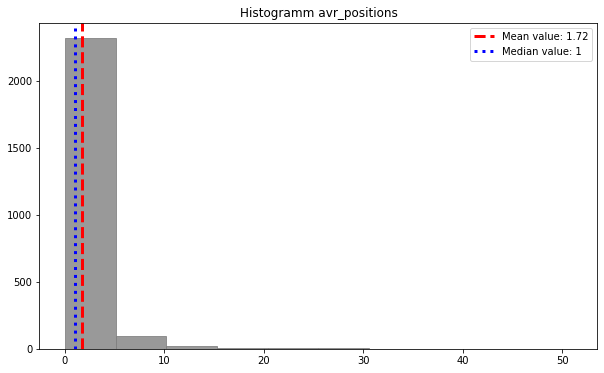

In [31]:
hist_maker(avg_positions_qty_by_users['avr_positions'], 10, 0, 51)

In [32]:
# считаем 95 и 99 перцентили
percentile(avg_positions_qty_by_users, 'avr_positions')
# проверим у какого % пользователей кол-во уникальных позиций > 1
display('Кол-во пользователей, которые покупают в среднем 1 товар на заказ:', avg_positions_qty_by_users[avg_positions_qty_by_users['avr_positions'] > 1].count())
display('% пользователей которые покупают в среднем в среднем 1 товар на заказ:', avg_positions_qty_by_users[avg_positions_qty_by_users['avr_positions'] > 1].count() / avg_positions_qty_by_users['avr_positions'].count())

Значения 95 и 99 перцентиля: [ 6.  14.5]
Значение 95 перцентиля: 6


'Кол-во пользователей, которые покупают в среднем 1 товар на заказ:'

customer_id      351
order_id         351
product          351
avr_positions    351
dtype: int64

'% пользователей которые покупают в среднем в среднем 1 товар на заказ:'

customer_id      0.143207
order_id         0.143207
product          0.143207
avr_positions    0.143207
dtype: float64

#### Комментарии
Только 14% клиентов имеют в заказах в среднем больше 1 позиции, остальные клиенты делают 1 заказ с 1 позицией.


Сформируем общую таблицу по покупателям с основными параметрами - кол-во заказов, средний чек, кол-во позиций из ассортимента в потреблении клиента.

In [33]:
# смерджим единую таблицу
common_client_table = avr_check_by_users.merge(products_qty_by_users, on = 'customer_id', how = 'left').sort_values(by = 'avr_check', ascending = False)
common_client_table = common_client_table.rename(columns={'product': 'product_name_qty'})
common_client_table = common_client_table[['customer_id', 'revenue', 'order_qty', 'avr_check', 'product_name_qty']]
common_client_table.head()

customer_id   revenue  order_qty  avr_check  \
0  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6  675000.0          1   675000.0   
1  146cd9bf-a95c-4afb-915b-5f6684b17444   49432.0          1    49432.0   
2  8fba3604-ef57-4b9f-b2fe-3402fa8825c8   33680.0          1    33680.0   
3  6987e6d6-a63a-4ce2-a2d0-f424092d235e   32718.0          1    32718.0   
4  58a4c3cc-504f-43ea-a74a-bae19e665552   53232.0          2    26616.0   

   product_name_qty  
0                 1  
1                 1  
2                 6  
3                 1  
4                 1

#### Среднее кол-во единиц продукции по клиентам

In [34]:
# подсчитаем среднее кол-во по клиентам в год
sales_qty_by_users = grouping_func(df, 'customer_id', 'quantity', 'mean')

count    2451.000000
mean        3.856607
std        24.331712
min         1.000000
25%         1.000000
50%         1.000000
75%         1.500000
max      1000.000000
Name: quantity, dtype: float64


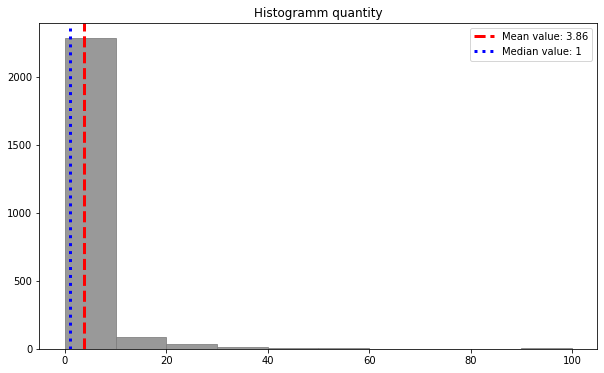

In [35]:
# построим гистограмму распределения по кол-ву позиций купленных за год
hist_maker(sales_qty_by_users['quantity'], 10, 0, 100)

In [36]:
# считаем 95 и 99 перцентили
percentile(sales_qty_by_users, 'quantity')

Значения 95 и 99 перцентиля: [10.  41.5]
Значение 95 перцентиля: 10


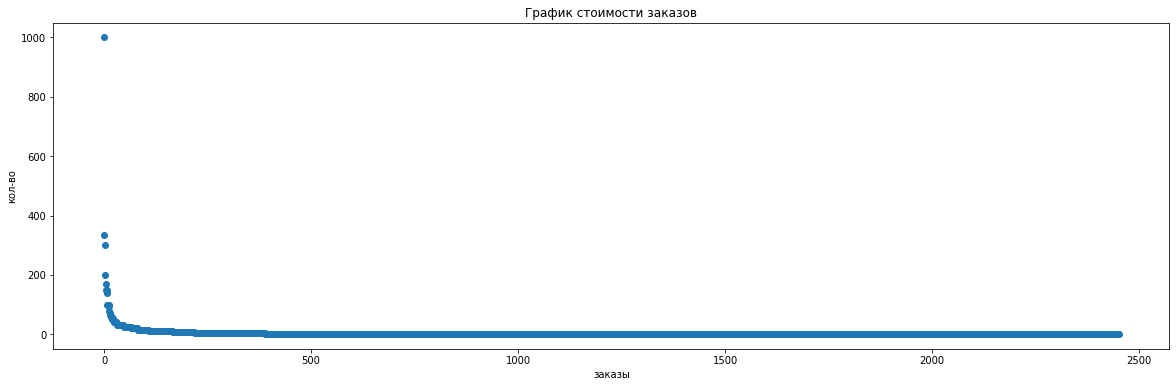

In [37]:
#построим гистограмму распределения по стоимостей заказов
x_values = pd.Series(range(0,len(sales_qty_by_users['quantity'])))
fig, ax= plt.subplots(1,1,figsize=(20, 6))
x= x_values
y1 = sales_qty_by_users['quantity']
ax.scatter(x, y1)
ax.set_title('График стоимости заказов')
ax.set_xlabel('заказы')
ax.set_ylabel('кол-во')
plt.show()

#### Комментарий
Разрыв между 95 и 99 перцентелями в 4 раза, целесообразно взять 95%, т.к. выше уже явные выбросы

In [38]:
display('Кол-во пользователей, которые в среднем покупали больше 1 штук товаров:', sales_qty_by_users[sales_qty_by_users['quantity'] > 1].count())
display('% пользователей которые купили больше 1 позиции:', orders_qty_by_users[sales_qty_by_users['quantity'] > 1].count() / sales_qty_by_users['quantity'].count())

'Кол-во пользователей, которые в среднем покупали больше 1 штук товаров:'

customer_id    687
quantity       687
dtype: int64

'% пользователей которые купили больше 1 позиции:'

customer_id    0.280294
order_qty      0.280294
dtype: float64

#### Комментарий
Большинство клиентов покупают 1 штуку товара (72%), но есть и выбросы, т.к. медиана и среднее значительно отличается. 
95% клиентов покупает не более 10 штук товара в среднем, а 99% не более 41.5 штук товара. За порог отсечения выбросов выбран 95 перцентиль

#### Промежуточный вывод
Таким образом, на основе анализа данных видно, что большинство клиентов:
- 93% клиентов совершили всего 1 заказ за период
- 86% клиентов совершают заказ в среднем с 1 позицией
- 82% клиентов купили более 1 товарной позиции за период
- 72% клиентов покупают товары в кол-ве 1 штуки

In [39]:
# смерджим единую таблицу
common_client_table = common_client_table.merge(sales_qty_by_users, on = 'customer_id', how = 'left')
common_client_table = common_client_table.rename(columns={'quantity': 'avr_qty'})
common_client_table = common_client_table[['customer_id', 'revenue', 'order_qty', 'avr_check', 'avr_qty', 'product_name_qty']]
common_client_table.head()

customer_id   revenue  order_qty  avr_check  \
0  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6  675000.0          1   675000.0   
1  146cd9bf-a95c-4afb-915b-5f6684b17444   49432.0          1    49432.0   
2  8fba3604-ef57-4b9f-b2fe-3402fa8825c8   33680.0          1    33680.0   
3  6987e6d6-a63a-4ce2-a2d0-f424092d235e   32718.0          1    32718.0   
4  58a4c3cc-504f-43ea-a74a-bae19e665552   53232.0          2    26616.0   

       avr_qty  product_name_qty  
0  1000.000000                 1  
1   334.000000                 1  
2    16.833333                 6  
3    57.000000                 1  
4    15.000000                 1

#### Анализ выбросов

In [40]:
# высчитаем переменные 99 перцентеля, чтобы использовать их для устранения выбросов
per_99_order_qty = percentile_99_var(common_client_table, 'order_qty')
per_99_avr_check = percentile_99_var(common_client_table, 'avr_check')
per_99_product_name_qty = percentile_99_var(common_client_table, 'product_name_qty')
per_95_avr_qty = percentile_95_var(common_client_table, 'avr_qty')
# Выведем значения перцентелей для колонок
print('99 перцентель для заказов:', per_99_order_qty)
print('99 перцентель для среднего чека:', per_99_avr_check)
print('99 перцентель для кол-ва купленных позиций:', per_99_product_name_qty)
print('95 перцентель среднего кол-ва в штуках:', per_95_avr_qty)

99 перцентель для заказов: 3
99 перцентель для среднего чека: 7797
99 перцентель для кол-ва купленных позиций: 18
95 перцентель среднего кол-ва в штуках: 10


In [41]:
# посмотрим выбросы
#client_anomalies = common_client_table.query('avr_check > @per_99_avr_check')
client_anomalies = common_client_table.query('order_qty > @per_99_order_qty \
                                            or avr_check > @per_99_avr_check \
                                            or product_name_qty > @per_99_product_name_qty \
                                            or avr_qty > @per_95_avr_qty')
print('Выручка по аномалиям:', client_anomalies['revenue'].sum())
display(client_anomalies)

Выручка по аномалиям: 1652419.0


customer_id   revenue  order_qty  avr_check  \
0     312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6  675000.0          1   675000.0   
1     146cd9bf-a95c-4afb-915b-5f6684b17444   49432.0          1    49432.0   
2     8fba3604-ef57-4b9f-b2fe-3402fa8825c8   33680.0          1    33680.0   
3     6987e6d6-a63a-4ce2-a2d0-f424092d235e   32718.0          1    32718.0   
4     58a4c3cc-504f-43ea-a74a-bae19e665552   53232.0          2    26616.0   
...                                    ...       ...        ...        ...   
1893  57cfa38a-325b-4b03-8419-cd4420053bdd     240.0          1      240.0   
1894  bd74b48f-17ea-45f7-8c66-510665aad57f     240.0          1      240.0   
1917  909530ce-406f-457a-8289-fc62cba16d14     231.0          1      231.0   
1948  23ca02ae-37c2-420d-b893-26f9cb262188     440.0          2      220.0   
2058  e0535076-6270-4df2-8621-cb06264a94fa     636.0          4      159.0   

          avr_qty  product_name_qty  
0     1000.000000                 1  
1      334.000000                 1  
2       16.833333                 6  
3       57.000000                 1  
4       15.000000                 1  
...           ...               ...  
1893    12.000000                 1  
1894    12.000000                 1  
1917    11.000000                 1  
1948    11.000000                 1  
2058     1.000000                 3  

[158 rows x 6 columns]

#### Комментарий
Аномалии по всем параметрам дают 39% выручки магазина, но их всего 6% от общего кол-ва.
Целесообразно проанализировать дополнительно явные выбросы, например, клиента с заказом на 675 тыс и клиента с 130 товарами в заказах.

In [42]:
# посмотрим клиента-лидера по среднему чеку
display(df.query('customer_id == "312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6"'))
# посмотрим клиента лидера по кол-ву товаров в заказах
display(df.query('customer_id == "c971fb21-d54c-4134-938f-16b62ee86d3b"'))

customer_id  order_id  \
4581  312e9a3e-5fca-43ff-a6a1-892d2b2d5ba6     71743   

                                                product  quantity  price  \
4581  вантуз с деревянной ручкой d14 см красный, bur...      1000  675.0   

      date_only    month   revenue  
4581 2019-06-18  2019-06  675000.0

customer_id  order_id  \
9     c971fb21-d54c-4134-938f-16b62ee86d3b     68480   
20    c971fb21-d54c-4134-938f-16b62ee86d3b     68490   
62    c971fb21-d54c-4134-938f-16b62ee86d3b     68511   
63    c971fb21-d54c-4134-938f-16b62ee86d3b     68514   
126   c971fb21-d54c-4134-938f-16b62ee86d3b     68561   
...                                    ...       ...   
2076  c971fb21-d54c-4134-938f-16b62ee86d3b     70582   
2078  c971fb21-d54c-4134-938f-16b62ee86d3b     70589   
2095  c971fb21-d54c-4134-938f-16b62ee86d3b     70606   
2099  c971fb21-d54c-4134-938f-16b62ee86d3b     70614   
2112  c971fb21-d54c-4134-938f-16b62ee86d3b     70629   

                                                product  quantity   price  \
9     чехол для гладильной доски colombo persia beig...         1   674.0   
20    чехол для гладильной доски festival 137x60 см ...         1  1162.0   
62    набор прищепок большие пластиковые rozenbal пи...        10    86.0   
63    сушилка для белья attribute прима 11 м синяя н...         1   749.0   
126   тележка багажная delta тбр-20 коричневый с ора...         1   742.0   
...                                                 ...       ...     ...   
2076                          нефролепис бостон d-12 см         1   292.0   
2078                       калла крупноцветковая желтая         1   374.0   
2095  пеларгония розебудная red pandora укорененный ...         1   134.0   
2099   гладильная доска ника lora fashion hlf 123х46 см         1  1949.0   
2112  сумка-тележка хозяйственная andersen scala sho...         1  3787.0   

      date_only    month  revenue  
9    2018-10-01  2018-10    674.0  
20   2018-10-02  2018-10   1162.0  
62   2018-10-03  2018-10    860.0  
63   2018-10-03  2018-10    749.0  
126  2018-10-08  2018-10    742.0  
...         ...      ...      ...  
2076 2019-03-04  2019-03    292.0  
2078 2019-03-04  2019-03    374.0  
2095 2019-03-05  2019-03    134.0  
2099 2019-03-05  2019-03   1949.0  
2112 2019-03-06  2019-03   3787.0  

[143 rows x 8 columns]

#### Комментарий
- Видно, что первый клиент - приобрел крупную партию вантузов. Он либо оптовый, либо это ошибка в кол-ве при заказе. Его целесообразно удалить из дальнейшего анализа, т.к. причину такого заказа нужно уточнить у смежных подразделений. Возможно он уже начал оформлять возврат. Приобрел он их в июне и этим как раз объясняется аномальный рост оборота в этот месяц.
- Второй клиент демонстрирует регулярное потребление, закупает широкий ассортимент, средний чек у него между средним и медианой - эталонный клиент

Таким образом, без клиента с заказом 675 тыс. выручка остальных клиентов-выбросов составляет около 23% магазина, при этом они составляют всего 5% от клиентов

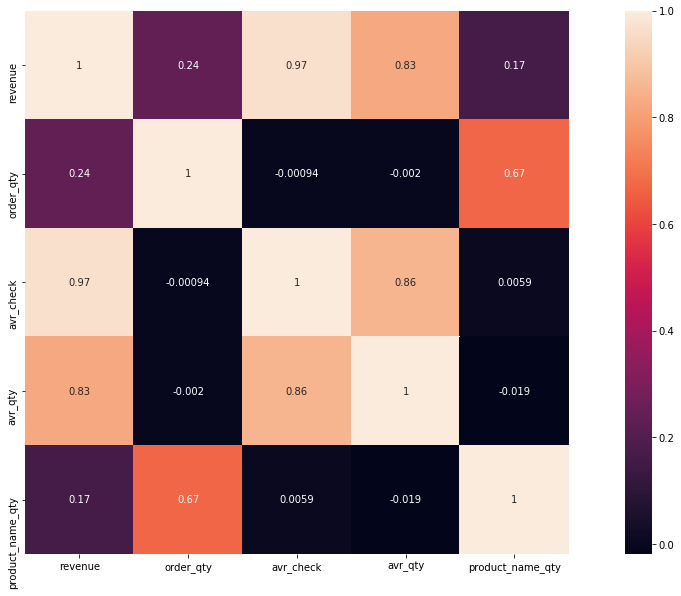

In [43]:
# cтроим матрицу корреляций по параметрам клиентов и наносим на heatmap
cm = common_client_table.corr()
fig, ax = plt.subplots(figsize=(20,10))
sns.heatmap(cm, annot = True, square=True) #ваш код здесь
plt.show()

#### Комментарий
На основе анализа можно сказать, что основная часть клиентов - розничные (1 заказ, кол-во 1-4 штуки и 1 конкретный товар). 
1. Средний чек включает в своем расчете выручку, корреляция высокая и целесообразно использовать его, т.к. он облегчает сравнение клиентов
1. Выбросы в среднем чеке сопряжены либо с ценами на товар, либо с крупным объемом заказа, либо с частотой заказов. 
    1. В случае цен - нельзя считать это выбросом, т.к. это специфика номенклатуры и в случае их исключения мы потеряем некоторое число обычных клиентов, которые просто заказали дорогой товар один раз
    2. Крупные объемы заказов можно считать выбросами, т.к. это описывает специфику клиента, **поэтому показатель среднего кол-во штук товара на клиента за период можно взять для устранения выбросов.**
    3. **Аномальная частота заказов также может считаться выбросом - описывает специфику клиента**

In [44]:
# уберем выбросы из агрегированной таблицы по клиентам
common_client_table_no_anomalies = common_client_table.query('avr_qty <= @per_95_avr_qty')
common_client_table_no_anomalies = common_client_table_no_anomalies.query('order_qty <= @per_99_order_qty')
display(common_client_table.info())
display(common_client_table_no_anomalies.info())

#создадим список аномальных id
normal_id_list = common_client_table_no_anomalies['customer_id'].to_list()
df = df.query('customer_id in @normal_id_list')
df['customer_id'].nunique()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2450
Data columns (total 6 columns):
customer_id         2451 non-null object
revenue             2451 non-null float64
order_qty           2451 non-null int64
avr_check           2451 non-null float64
avr_qty             2451 non-null float64
product_name_qty    2451 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 134.0+ KB


None

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2323 entries, 5 to 2450
Data columns (total 6 columns):
customer_id         2323 non-null object
revenue             2323 non-null float64
order_qty           2323 non-null int64
avr_check           2323 non-null float64
avr_qty             2323 non-null float64
product_name_qty    2323 non-null int64
dtypes: float64(3), int64(2), object(1)
memory usage: 127.0+ KB


None

2323

In [45]:
df['revenue'].describe()

count     4457.000000
mean       605.706305
std       1113.485513
min          9.000000
25%        120.000000
50%        188.000000
75%        637.000000
max      24370.000000
Name: revenue, dtype: float64

#### Вывод
- Активность клиентов магазина низкая, у большинства клиентов 1 заказ с 1 штукой 1 наименования товаров за период
- Были удалены из анализа 128 клиентов-выбросов (5%) на основе перцентильного анализа по среднему объему товаров в штуках на клиента(95 перцентиль) и аномальной частоте заказов(99 перцентиль)

### Анализ товаров

#### Категоризация продуктов по названиям

In [46]:
#сформируем отдельный список продуктов с продажами
products = df['product']
products = products.drop_duplicates()
df_products = products.to_frame()
df_products.head()

product
0    комнатное растение в горшке алое вера, d12, h30
1  комнатное растение в горшке кофе арабика, d12,...
2                        радермахера d-12 см h-20 см
3                   хризолидокарпус лутесценс d-9 см
4                     циперус зумула d-12 см h-25 см

In [47]:
def lemma(data):
#преобразование в единый текст-строку
    product_unique_str = ' '.join(data)
#подсчет частоты лемм в столбце purpose 
    lemmas = m.lemmatize(product_unique_str)
    lemmas_counted = Counter(lemmas)
#вывод
    return lemmas_counted

#формируем столбец с леммами для каждой строчки данных
def lemmatization(row):
        lemmas = m.lemmatize(row)
        return lemmas

In [48]:
# Выводим все леммы
print(lemma(df_products['product']))

Counter({' ': 16361, ', ': 991, 'см': 990, '-': 901, 'для': 508, ',': 278, 'в': 257, 'd': 246, 'л': 236, 'с': 222, 'рассада': 208, '5': 181, 'кассета': 167, 'шт': 160, 'сорт': 159, '0': 158, 'белый': 152, ' (': 152, 'белье': 140, '12': 138, 'красный': 134, 'горшок': 127, ') ': 126, '/': 121, '9': 120, 'доска': 120, 'сушилка': 116, 'объем': 114, '6': 108, 'цветок': 106, 'гладильный': 103, '2': 103, 'тележка': 102, '1': 101, 'по': 97, '. ': 97, '4': 96, '10': 95, 'сумка': 93, 'диам': 92, 'томат': 88, 'пеларгония': 86, '*': 83, 'розовый': 82, '3': 81, 'помидор': 81, '№': 79, 'из': 76, 'и': 74, 'luminarc': 72, '7': 72, 'хозяйственный': 72, 'ника': 72, 'кухня': 71, 'gimi': 70, 'ванный': 70, 'коврик': 69, '20': 68, 'зелень': 68, 'муляж': 68, 'среднеспелый': 68, 'мл': 64, 'махровый': 62, 'роза': 62, 'зональный': 61, 'черный': 61, 'синий': 60, 'г': 60, 'h': 58, 'м': 58, 'чехол': 54, 'однолетний': 54, 'искусственный': 52, '100': 51, 'комната': 51, 'штора': 51, 'пластмассовый': 50, '30': 49, 'шт

In [49]:
df_products['lemmas'] = df_products['product'].apply(lemmatization)
df_products.head()

product  \
0    комнатное растение в горшке алое вера, d12, h30   
1  комнатное растение в горшке кофе арабика, d12,...   
2                        радермахера d-12 см h-20 см   
3                   хризолидокарпус лутесценс d-9 см   
4                     циперус зумула d-12 см h-25 см   

                                              lemmas  
0  [комнатный,  , растение,  , в,  , горшок,  , а...  
1  [комнатный,  , растение,  , в,  , горшок,  , к...  
2  [радермахер,  , d, -, 12,  , см,  , h, -, 20, ...  
3  [хризолидокарпус,  , лутесценс,  , d, -, 9,  ,...  
4  [циперус,  , зумул,  , d, -, 12,  , см,  , h, ...

In [50]:
# функция категоризации
def categorization(data):
#растения
        if 'рассада' in data \
        or 'd' in data \
        or 'горшок' in data \
        or 'кашпо' in data \
        or 'пеларгония' in data \
        or 'петуния' in data \
        or 'герань' in data \
        or 'кассета' in data \
        or 'цикламен' in data \
        or 'роза' in data \
        or 'флокс' in data \
        or 'микс' in data \
        or 'объем' in data \
        or 'примула' in data \
        or 'упаковка' in data \
        or 'раннеспелый' in data \
        or 'мята' in data \
        or 'дыня' in data \
        or 'фиалка' in data \
        or 'бальзамин' in data \
        or 'пуансеттия' in data \
        or 'андрианум' in data \
        or 'антуриум' in data \
        or 'ампельный' in data \
        or 'косметь' in data \
        or 'клубника' in data \
        or 'растение' in data:
            return 1
# декор(искусственные растения)
        if 'цветок' in data \
        or 'томат' in data \
        or 'помидор' in data\
        or 'муляж' in data:
            return 2
#белье и одежда
        if 'белье' in data \
        or 'наматрацник' in data \
        or 'покрывало' in data \
        or 'сушилка' in data \
        or 'доска' in data \
        or 'вешалка' in data \
        or 'корзина' in data \
        or 'одежда' in data \
        or 'обувь' in data \
        or 'wellness' in data \
        or 'чехол' in data \
        or 'плечики' in data \
        or 'прищепок' in data \
        or 'eurogold' in data:
            return 3
#крупные емкости
        if 'тележка' in data \
        or 'таз' in data \
        or 'уличная' in data \
        or 'корыто' in data \
        or 'мусорный контейнер' in data \
        or 'бидон' in data \
        or 'ведро' in data:
            return 4
#товары для кухни
        if 'крышка' in data \
        or 'скатерть' in data \
        or 'салфетка' in data \
        or 'нож' in data \
        or 'чайник' in data \
        or 'webber' in data \
        or 'attribute' in data \
        or 'посуда' in data \
        or 'стакан' in data \
        or 'термокружок'in data \
        or 'кружка' in data \
        or 'банка' in data \
        or 'сковорода' in data \
        or 'ложка' in data \
        or 'кастрюля' in data \
        or 'прибор' in data \
        or 'контейнер' in data \
        or 'электроштопор' in data \
        or 'салатник' in data \
        or 'curver' in data \
        or 'термос' in data \
        or 'вилка' in data \
        or 'одежный' in data \
        or 'посудомоечный' in data \
        or 'luminarc' in data:
            return 5
#товары для ванной
        if 'ванна' in data \
        or 'ванный' in data \
        or 'штора' in data \
        or 'вантуз' in data \
        or 'унитаз' in data \
        or 'ерш' in data \
        or 'средство' in data \
        or 'wc'in data:      
            return 6
#товары для уборки
        if 'rozenbal' in data \
        or 'щетка' in data \
        or 'leifheit' in data \
        or 'мусор' in data \
        or 'совок' in data \
        or 'швабра' in data:
            return 7
#товары для хранения
        if 'хранение' in data \
        or 'valiant' in data \
        or 'qwerty' in data:   
            return 8
#напольные покрытия   
        if 'коврик' in data \
        or 'ковер' in data:
            return 9
#стремянки
        if 'стремянка' in data:
            return 10
#прочее
        else:
            return 0
df_products['product_id'] = df_products['lemmas'].apply(categorization)
display(df_products.query('product_id == 0').head(20))

product  \
72         дозатор для мыла hausmann белый hm-b0194r-2   
162        стяжка оконная с болтом ст-55 цинк, 1108354   
182  противень прямоугольный алюминиевый 340х240х25...   
235  миксер delta lux dl-5068 серо-голубой 400 вт 4...   
240  чистящий крем для трудновыводимых пятен mama l...   
248  tepмокружка avex recharge 500 мл голубой avex0681   
290  жидкое мыло vestar хозяйственное 750 мл россия...   
306                        подрукавник складной ника п   
319  набор сверел по дереву из 8 шт, 3-10 мм *888* ...   
320  сверло-фреза, 6 мм, нитрид титана *888* 686206...   
321  сверло-фреза, 8 мм, нитрид титана *888* 686208...   
338  зубная паста zact с эффектом отбеливания кофей...   
339  зубная паста zact lion smokers toothpaste 100 ...   
340  зубная паста zact lion whitening toothpaste 10...   
438            ножеточка универсальная "рыбка" 1519028   
520  утюг электрический с керамическим покрытием de...   
538  холодная сварка mastix 55г для труб и батарей,...   
539  холодная сварка mastix 55г универсальная, 1205037   
634  урна уличная "гео", hobbyka/хоббика, 59*37,5см...   
647  мыло жидкое reffil mama utimate облепиха 500 м...   

                                                lemmas  product_id  
72   [дозатор,  , для,  , мыло,  , hausmann,  , бел...           0  
162  [стяжка,  , оконный,  , с,  , болт,  , ст, -, ...           0  
182  [противень,  , прямоугольный,  , алюминиевый, ...           0  
235  [миксер,  , delta,  , lux,  , dl, -, 5068,  , ...           0  
240  [чистить,  , крем,  , для,  , трудновыводимый,...           0  
248  [tepмокружка,  , avex,  , recharge,  , 500,  ,...           0  
290  [жидкий,  , мыло,  , vestar,  , хозяйственный,...           0  
306      [подрукавник,  , складной,  , ника,  , п, \n]           0  
319  [набор,  , свереть,  , по,  , дерево,  , из,  ...           0  
320  [сверло, -, фреза, , , 6,  , мм, , , нитрид,  ...           0  
321  [сверло, -, фреза, , , 8,  , мм, , , нитрид,  ...           0  
338  [зубной,  , паста,  , zact,  , с,  , эффект,  ...           0  
339  [зубной,  , паста,  , zact,  , lion,  , smoker...           0  
340  [зубной,  , паста,  , zact,  , lion,  , whiten...           0  
438  [ножеточка,  , универсальный,  ", рыбка, " , 1...           0  
520  [утюг,  , электрический,  , с,  , керамический...           0  
538  [холодный,  , сварка,  , mastix,  , 55г,  , дл...           0  
539  [холодный,  , сварка,  , mastix,  , 55г,  , ун...           0  
634  [урна,  , уличный,  ", гео, ", , hobbyka, /, х...           0  
647  [мыло,  , жидкий,  , reffil,  , mama,  , utima...           0

In [51]:
# проверка лемм нулевой категории
print(df_products.query('product_id == 0')['lemmas'].count())

154


In [52]:
print(lemma(df_products.query('product_id == 0')['product']))

Counter({' ': 1048, ', ': 77, '-': 57, 'г': 39, ',': 36, '0': 28, 'для': 23, 'см': 23, 'с': 21, '5': 19, '1': 16, '3': 13, '2': 12, 'шт': 12, '/': 11, 'вт': 10, 'мм': 10, 'мл': 9, 'на': 9, 'алюминиевый': 8, 'delta': 8, 'л': 8, 'ручка': 8, 'мыло': 7, 'dl': 7, 'россия': 7, '10': 7, '6': 7, 'в': 7, 'белый': 6, 'зубной': 6, 'паста': 6, '100': 6, '*': 6, '20': 6, '.': 6, ' (': 6, 'металлический': 6, 'из': 5, 'урна': 5, 'уличный': 5, 'сталь': 5, 'красный': 5, 'оранжевый': 5, '4': 4, '500': 4, 'набор': 4, ' *': 4, '888': 4, 'и': 4, ' "': 4, 'зеленый': 4, 'truper': 4, 'h': 4, 'крючок': 4, 'деревянный': 4, 'весы': 4, 'м': 4, ') ': 4, 'цинния': 4, 'hausmann': 3, 'hm': 3, 'scovo': 3, 'миксер': 3, 'lux': 3, 'режим': 3, 'гр': 3, 'tepмокружка': 3, 'avex': 3, 'хозяйственный': 3, '8': 3, '* ': 3, 'zact': 3, 'универсальный': 3, '" ': 3, 'утюг': 3, 'электрический': 3, 'керамический': 3, 'hobbyka': 3, 'хоббик': 3, 'хозлэнд': 3, '30': 3, 'длина': 3, '25': 3, 'полимербыт': 3, 'р': 3, 'черный': 3, 'мощность

In [53]:
#Проверка отдельных лемм
display(df_products[(df_products['product'].str.contains('уличная') & (df_products['product_id'] == 0))].head(20))

product  \
634   урна уличная "гео", hobbyka/хоббика, 59*37,5см...   
5236  урна уличная стальная сальвадор 02.021.0 46х11...   
5726  урна уличная стальная юпитер 02.012.0 38х38х60 см   

                                                 lemmas  product_id  
634   [урна,  , уличный,  ", гео, ", , hobbyka, /, х...           0  
5236  [урна,  , уличный,  , стальной,  , сальвадор, ...           0  
5726  [урна,  , уличный,  , стальной,  , юпитер,  , ...           0

#### Комментарий
Можно выделить следующие категории и присвоить им id:
- Растения 1
- Декор и искусственные растения 2
- Белье и одежда 3
- Крупные емкости (тазы, тележки, ведра) 4
- Товары для кухни 5
- Товары для ванной 6
- Товары для уборки 7
- Решения для хранения 8
- Напольные покрытия 9
- Стремянки 10
- Прочее 0

Сформируем словарь

In [54]:
#присвоение названий id категорий
category_df = pd.DataFrame([[1, 'растения'], 
                            [2,'декор'], 
                            [3,'белье_и_одежда'], 
                            [4,'крупные_емкости'],
                            [5,'товары_для_кухни'],
                            [6,'товары_для_ванной'],
                            [7,'уборка'],
                            [8, 'товары_для_хранения'],
                            [9, 'напольные_покрытия'],
                            [10, 'стремянки'],                            
                            [0, 'прочее']], columns=['product_id','category_name'])
category_df.head()

product_id     category_name
0           1          растения
1           2             декор
2           3    белье_и_одежда
3           4   крупные_емкости
4           5  товары_для_кухни

In [55]:
#подтянем id продуктовых групп к базе данных
df = df.merge(df_products, on = 'product', how = 'left')
df.head()

customer_id  order_id  \
0  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  \
0    комнатное растение в горшке алое вера, d12, h30         1  142.0   
1  комнатное растение в горшке кофе арабика, d12,...         1  194.0   
2                        радермахера d-12 см h-20 см         1  112.0   
3                   хризолидокарпус лутесценс d-9 см         1  179.0   
4                     циперус зумула d-12 см h-25 см         1  112.0   

   date_only    month  revenue  \
0 2018-10-01  2018-10    142.0   
1 2018-10-01  2018-10    194.0   
2 2018-10-01  2018-10    112.0   
3 2018-10-01  2018-10    179.0   
4 2018-10-01  2018-10    112.0   

                                              lemmas  product_id  
0  [комнатный,  , растение,  , в,  , горшок,  , а...           1  
1  [комнатный,  , растение,  , в,  , горшок,  , к...           1  
2  [радермахер,  , d, -, 12,  , см,  , h, -, 20, ...           1  
3  [хризолидокарпус,  , лутесценс,  , d, -, 9,  ,...           1  
4  [циперус,  , зумул,  , d, -, 12,  , см,  , h, ...           1

In [56]:
df = df.merge(category_df, on = 'product_id', how = 'left')
df.head()

customer_id  order_id  \
0  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
1  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
2  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
3  ee47d746-6d2f-4d3c-9622-c31412542920     68477   
4  ee47d746-6d2f-4d3c-9622-c31412542920     68477   

                                             product  quantity  price  \
0    комнатное растение в горшке алое вера, d12, h30         1  142.0   
1  комнатное растение в горшке кофе арабика, d12,...         1  194.0   
2                        радермахера d-12 см h-20 см         1  112.0   
3                   хризолидокарпус лутесценс d-9 см         1  179.0   
4                     циперус зумула d-12 см h-25 см         1  112.0   

   date_only    month  revenue  \
0 2018-10-01  2018-10    142.0   
1 2018-10-01  2018-10    194.0   
2 2018-10-01  2018-10    112.0   
3 2018-10-01  2018-10    179.0   
4 2018-10-01  2018-10    112.0   

                                              lemmas  product_id category_name  
0  [комнатный,  , растение,  , в,  , горшок,  , а...           1      растения  
1  [комнатный,  , растение,  , в,  , горшок,  , к...           1      растения  
2  [радермахер,  , d, -, 12,  , см,  , h, -, 20, ...           1      растения  
3  [хризолидокарпус,  , лутесценс,  , d, -, 9,  ,...           1      растения  
4  [циперус,  , зумул,  , d, -, 12,  , см,  , h, ...           1      растения

In [57]:
# выгружаем датасет для Tableau общий датасет
df.to_csv('df_ecommerce.csv', index = False)
orders_sum_by_date = df.pivot_table(index = ['date_only', 'order_id'], values = 'revenue', aggfunc = 'sum').reset_index()
orders_sum_by_date.to_csv('orders_sum_by_dates.csv', index = False)

In [58]:
# проверка
display(df.query('date_only == "2019-01-15"'))

customer_id  order_id  \
1109  f71a41ab-df06-4c9f-a4bf-474e368a40d2     69826   
1110  3d573784-59f3-49d3-b7ba-65a2e7d55f14     69827   
1111  ecefadc1-e7f3-4026-a5e7-1cf00195148b     69828   
1112  ecefadc1-e7f3-4026-a5e7-1cf00195148b     69829   
1113  631c5729-d163-4270-8956-4d9832085d0e     69833   

                                                product  quantity   price  \
1109  вешалка-плечики без эссенции цвет тёмно-розовы...         3    45.0   
1110  скатерть беатрис 50% полиэфир 50% хлопок прямо...         1  1724.0   
1111                                муляж морковь 16 см         1    59.0   
1112                               муляж баклажан 18 см         1    59.0   
1113  чехол eurogold clean metallic металлизированый...         2   299.0   

      date_only    month  revenue  \
1109 2019-01-15  2019-01    135.0   
1110 2019-01-15  2019-01   1724.0   
1111 2019-01-15  2019-01     59.0   
1112 2019-01-15  2019-01     59.0   
1113 2019-01-15  2019-01    598.0   

                                                 lemmas  product_id  \
1109  [вешалка, -, плечики,  , без,  , эссенция,  , ...           3   
1110  [скатерть,  , беатрис,  , 50, % , полиэфир,  ,...           3   
1111              [муляж,  , морковь,  , 16,  , см, \n]           2   
1112             [муляж,  , баклажан,  , 18,  , см, \n]           2   
1113  [чехол,  , eurogold,  , clean,  , metallic,  ,...           3   

       category_name  
1109  белье_и_одежда  
1110  белье_и_одежда  
1111           декор  
1112           декор  
1113  белье_и_одежда

#### Оборот по категориям

In [59]:
TOP10_produts_by_cat = pivot_func(df,['product', 'category_name'], ['revenue','quantity'], 'sum')
TOP10_produts_by_cat.query('category_name == "прочее"').head(10)
#display(grouping_func(df, ['product', , 'order_id', 'nunique')

quantity  \
product                                            category_name             
урна уличная "гео", hobbyka/хоббика, 59*37,5см,... прочее                5   
урна уличная стальная сальвадор 02.021.0 46х110 см прочее                1   
урна уличная стальная юпитер 02.012.0 38х38х60 см  прочее                1   
набор инструментов в алюминиевом кейсе на колес... прочее                1   
паста зубная для профилактики заболеваний десен... прочее                6   
урна-пепельница из нержавеющей стали, hobbyka/х... прочее                1   
tepмокружка avex recharge 500 мл голубой avex0681  прочее                2   
комод эльфпласт № 3 алфавит оранжевый 301о         прочее                3   
весы напольные электронные soehnle pino white, ... прочее                1   
весы электронные кухонные soehnle (круглые,20 с... прочее                2   

                                                                  revenue  
product                                            category_name           
урна уличная "гео", hobbyka/хоббика, 59*37,5см,... прочее         24370.0  
урна уличная стальная сальвадор 02.021.0 46х110 см прочее          7349.0  
урна уличная стальная юпитер 02.012.0 38х38х60 см  прочее          6899.0  
набор инструментов в алюминиевом кейсе на колес... прочее          5399.0  
паста зубная для профилактики заболеваний десен... прочее          5394.0  
урна-пепельница из нержавеющей стали, hobbyka/х... прочее          5287.0  
tepмокружка avex recharge 500 мл голубой avex0681  прочее          4198.0  
комод эльфпласт № 3 алфавит оранжевый 301о         прочее          4047.0  
весы напольные электронные soehnle pino white, ... прочее          2849.0  
весы электронные кухонные soehnle (круглые,20 с... прочее          2548.0

In [60]:
# построим сводную по обороту по продуктовым группам
TO_by_product = pivot_func(df, 'category_name', 'revenue', 'sum').reset_index()
TO_by_product['share'] = TO_by_product['revenue'] / TO_by_product['revenue'].sum()
TO_by_product['share'] = TO_by_product['revenue'] / TO_by_product['revenue'].sum()
TO_by_product['share']= TO_by_product['share'].map('{:.0%}'.format)
display(TO_by_product)

category_name   revenue share
0        белье_и_одежда  734902.0   27%
1       крупные_емкости  665713.0   25%
2              растения  486479.0   18%
3      товары_для_кухни  195483.0    7%
4     товары_для_ванной  142821.0    5%
5                прочее  130151.0    5%
6             стремянки   98922.0    4%
7    напольные_покрытия   73972.0    3%
8   товары_для_хранения   72609.0    3%
9                уборка   59664.0    2%
10                декор   38917.0    1%

In [61]:
# построим столбчатую горизонтальную диаграмму по доли в обороте
fig = px.bar(TO_by_product, x ='share', y='category_name', text = 'share', title='Оборот по группам товаров', labels=dict(category_name ="название категории", share ="доля в обороте") , orientation = 'h', width=800, height=800)
# сделаем порядок сортировки колонок от большего к меньшему
fig.update_yaxes(autorange="reversed")
fig.show()

#### Комментраий
ТОП-4 сегмента товаров - это белье и одежда, крупные емкости, растения и товары для кухни -  ок 80% оборота.

Остальные товары генерят значительно меньше выручки.

#### Сезонность по продуктам

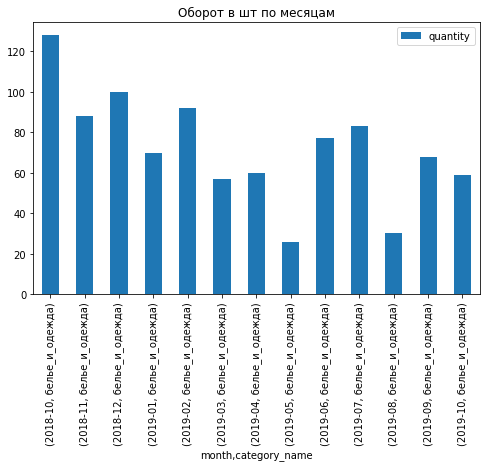

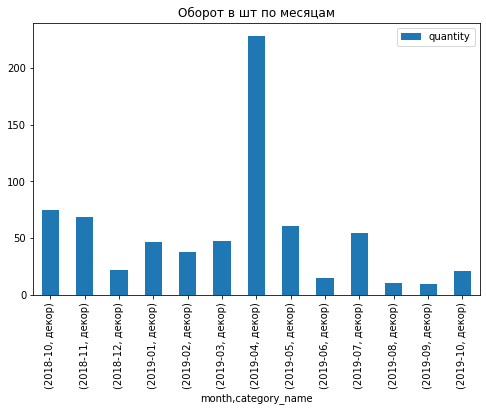

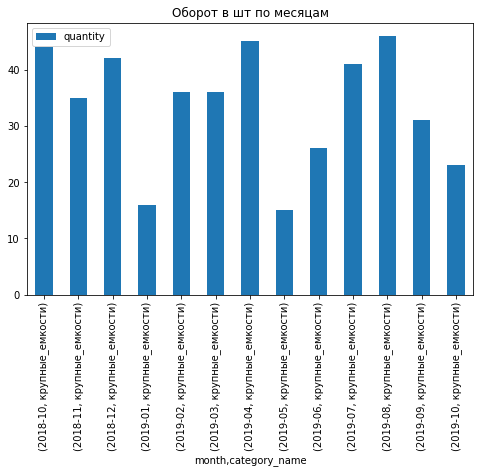

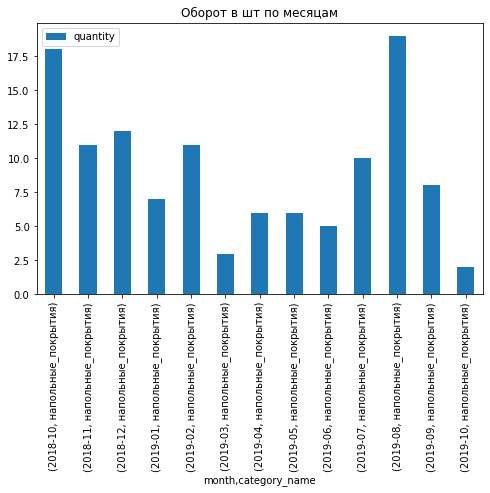

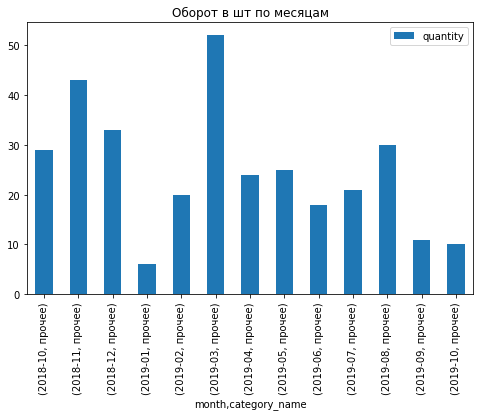

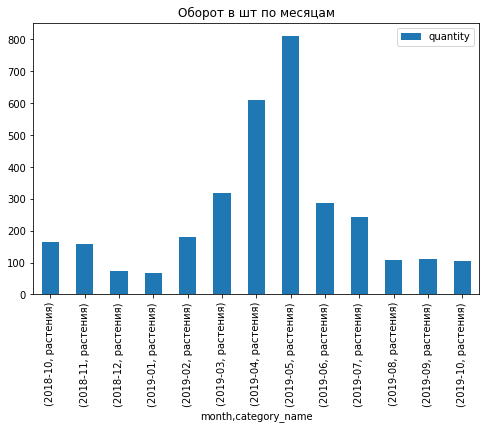

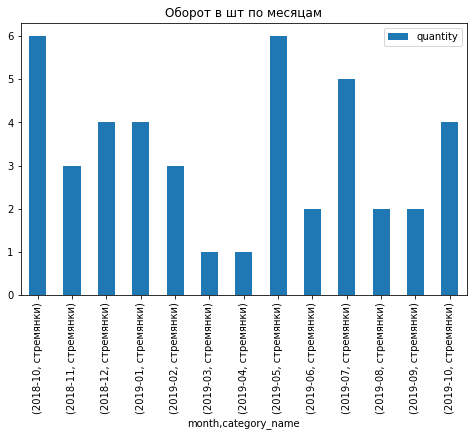

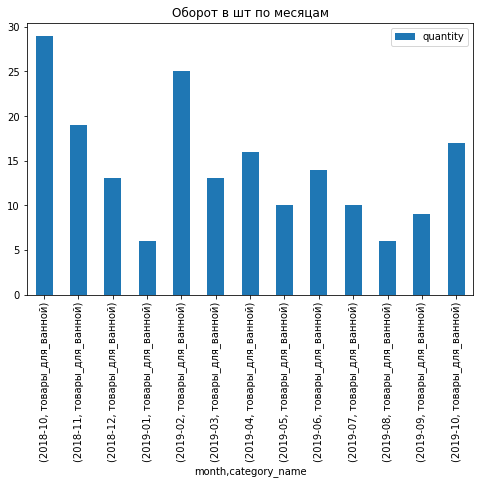

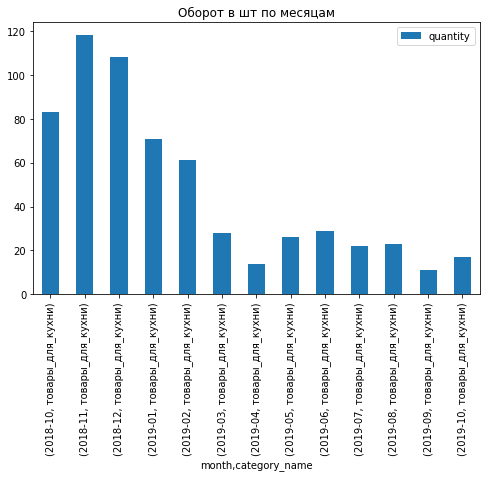

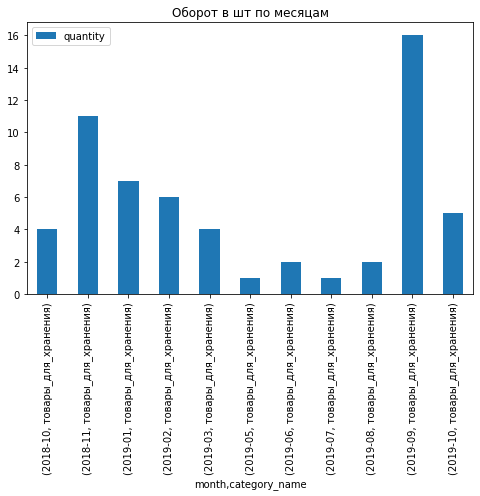

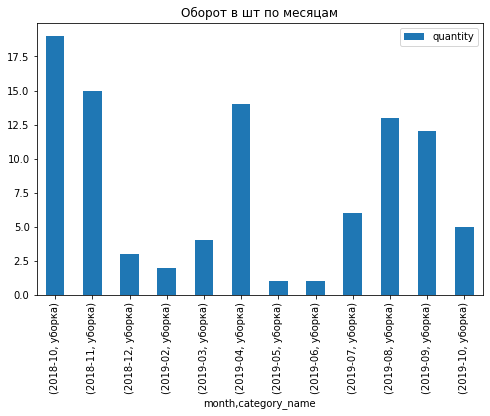

In [62]:
df_select_cat_TO = df.pivot_table(index=['month', 'category_name'], values='quantity', aggfunc=['sum'])
df_select_cat_TO.columns = ['quantity']
for name, group_data in df_select_cat_TO.groupby('category_name'):
    group_data.plot(kind = 'bar', y='quantity', figsize = (8,5),  title = 'Оборот в шт по месяцам')

#### Комментарий
На основе анализа сезонности видно, что явную сезонность имеют растения - рост с март по май.

У других категорий она менее выражена

#### Вывод
1. На основе лемматизации выделено 11 групп товаров:
    - Растения 1
    - Декор и искусственные растения 2
    - Белье и одежда 3
    - Крупные емкости (тазы, тележки, ведра) 4
    - Товары для кухни 5
    - Товары для ванной 6
    - Товары для уборки 7
    - Решения для хранения 8
    - Напольные покрытия 9
    - Стремянки 10
    - Прочее 0
2. Установлены ТОП-4 сегмента товаров - это белье и одежда, крупные емкости, растения и товары для кухни -  ок 80% оборота.
3. Выявлена сезонность по группе растений

### Вывод по исследовательскому анализу

На основе анализа клиентов и товаров установлены:
- Низкая активность клиентов и минимальное кол-во возвратов
- 11 категорий товаров для дальнейшей сегментации клиентов

## Кластеризация

In [63]:
# построим сводную таблицу с подсчетом кол-ва товаров, приобретенных клиентами по разным категориям
client_categories = df.pivot_table(index = 'customer_id', columns = 'category_name', values= 'revenue', aggfunc=['sum']).reset_index()
client_categories.columns = client_categories.columns.get_level_values(1)
client_categories = client_categories.rename(columns={'': 'customer_id'})
display(client_categories.head())

category_name                           customer_id  белье_и_одежда  декор  \
0              000d6849-084e-4d9f-ac03-37174eaf60c4             NaN    NaN   
1              001cee7f-0b29-4716-b202-0042213ab038           442.0    NaN   
2              00299f34-5385-4d13-9aea-c80b81658e1b             NaN    NaN   
3              002d4d3a-4a59-406b-86ec-c3314357e498             NaN    NaN   
4              003bbd39-0000-41ff-b7f9-2ddaec152037          2324.0    NaN   

category_name  крупные_емкости  напольные_покрытия  прочее  растения  \
0                          NaN                 NaN     NaN     555.0   
1                          NaN                 NaN     NaN       NaN   
2                          NaN                 NaN     NaN       NaN   
3                       1649.0                 NaN     NaN       NaN   
4                          NaN                 NaN     NaN       NaN   

category_name  стремянки  товары_для_ванной  товары_для_кухни  \
0                    NaN                NaN               NaN   
1                    NaN                NaN               NaN   
2                    NaN                NaN               NaN   
3                    NaN                NaN               NaN   
4                    NaN                NaN               NaN   

category_name  товары_для_хранения  уборка  
0                              NaN     NaN  
1                              NaN     NaN  
2                              NaN   914.0  
3                              NaN     NaN  
4                              NaN     NaN

In [64]:
# заменим ненулевые значения с кол-вом товаров на 1 как факт приобретения товара из категории и 0, если в категории товары не приобретались
client_categories_logic = client_categories.fillna(0)
client_categories_logic['сумма'] = client_categories_logic[['белье_и_одежда','декор','крупные_емкости', 'напольные_покрытия', 'прочее', 'растения', 'стремянки', 'товары_для_ванной', 'товары_для_кухни', 'товары_для_хранения', 'уборка']].sum(axis=1)
display(client_categories_logic.head())

category_name                           customer_id  белье_и_одежда  декор  \
0              000d6849-084e-4d9f-ac03-37174eaf60c4             0.0    0.0   
1              001cee7f-0b29-4716-b202-0042213ab038           442.0    0.0   
2              00299f34-5385-4d13-9aea-c80b81658e1b             0.0    0.0   
3              002d4d3a-4a59-406b-86ec-c3314357e498             0.0    0.0   
4              003bbd39-0000-41ff-b7f9-2ddaec152037          2324.0    0.0   

category_name  крупные_емкости  напольные_покрытия  прочее  растения  \
0                          0.0                 0.0     0.0     555.0   
1                          0.0                 0.0     0.0       0.0   
2                          0.0                 0.0     0.0       0.0   
3                       1649.0                 0.0     0.0       0.0   
4                          0.0                 0.0     0.0       0.0   

category_name  стремянки  товары_для_ванной  товары_для_кухни  \
0                    0.0                0.0               0.0   
1                    0.0                0.0               0.0   
2                    0.0                0.0               0.0   
3                    0.0                0.0               0.0   
4                    0.0                0.0               0.0   

category_name  товары_для_хранения  уборка   сумма  
0                              0.0     0.0   555.0  
1                              0.0     0.0   442.0  
2                              0.0   914.0   914.0  
3                              0.0     0.0  1649.0  
4                              0.0     0.0  2324.0

In [65]:
# высчитаем долю каждого сегмента - параметра в общем обороте, разделив каждый столбец на их сумму
client_categories_logic.iloc[:, 1:12] = client_categories_logic.iloc[:, 1:12].div(client_categories_logic['сумма'], 0)
client_categories_logic.head(10)

category_name                           customer_id  белье_и_одежда  декор  \
0              000d6849-084e-4d9f-ac03-37174eaf60c4             0.0    0.0   
1              001cee7f-0b29-4716-b202-0042213ab038             1.0    0.0   
2              00299f34-5385-4d13-9aea-c80b81658e1b             0.0    0.0   
3              002d4d3a-4a59-406b-86ec-c3314357e498             0.0    0.0   
4              003bbd39-0000-41ff-b7f9-2ddaec152037             1.0    0.0   
5              005ba170-45e8-42de-93f7-192481ae2659             0.0    0.0   
6              00bd74b1-2792-47db-a2f1-680a09ac5026             1.0    0.0   
7              00c0f92a-121a-4883-a78d-2c7b5fe187de             0.0    0.0   
8              00c95d20-923e-4b45-88fc-53b12931d462             0.0    0.0   
9              00cd704a-a65c-4865-b39a-779f1b4f1d1a             0.0    0.0   

category_name  крупные_емкости  напольные_покрытия  прочее  растения  \
0                          0.0                 0.0     0.0       1.0   
1                          0.0                 0.0     0.0       0.0   
2                          0.0                 0.0     0.0       0.0   
3                          1.0                 0.0     0.0       0.0   
4                          0.0                 0.0     0.0       0.0   
5                          0.0                 0.0     0.0       0.0   
6                          0.0                 0.0     0.0       0.0   
7                          0.0                 0.0     0.0       1.0   
8                          0.0                 0.0     1.0       0.0   
9                          0.0                 0.0     0.0       1.0   

category_name  стремянки  товары_для_ванной  товары_для_кухни  \
0                    0.0                0.0               0.0   
1                    0.0                0.0               0.0   
2                    0.0                0.0               0.0   
3                    0.0                0.0               0.0   
4                    0.0                0.0               0.0   
5                    0.0                1.0               0.0   
6                    0.0                0.0               0.0   
7                    0.0                0.0               0.0   
8                    0.0                0.0               0.0   
9                    0.0                0.0               0.0   

category_name  товары_для_хранения  уборка   сумма  
0                              0.0     0.0   555.0  
1                              0.0     0.0   442.0  
2                              0.0     1.0   914.0  
3                              0.0     0.0  1649.0  
4                              0.0     0.0  2324.0  
5                              0.0     0.0  1199.0  
6                              0.0     0.0   937.0  
7                              0.0     0.0   134.0  
8                              0.0     0.0   959.0  
9                              0.0     0.0   112.0

In [66]:
# Стандартизация данных
scaler = StandardScaler()
# стандартизируем признаки
df_sc_1 = client_categories_logic.drop(['customer_id', 'сумма'], axis = 1)
df_sc_1.loc[:, df_sc_1.columns] = scaler.fit_transform(df_sc_1.loc[:, df_sc_1.columns])
x_sc_1 = df_sc_1
display(x_sc_1.head())

category_name  белье_и_одежда     декор  крупные_емкости  напольные_покрытия  \
0                   -0.568467 -0.224768        -0.419364           -0.178245   
1                    1.784503 -0.224768        -0.419364           -0.178245   
2                   -0.568467 -0.224768        -0.419364           -0.178245   
3                   -0.568467 -0.224768         2.393250           -0.178245   
4                    1.784503 -0.224768        -0.419364           -0.178245   

category_name    прочее  растения  стремянки  товары_для_ванной  \
0             -0.241472  1.569490  -0.128739          -0.232254   
1             -0.241472 -0.649503  -0.128739          -0.232254   
2             -0.241472 -0.649503  -0.128739          -0.232254   
3             -0.241472 -0.649503  -0.128739          -0.232254   
4             -0.241472 -0.649503  -0.128739          -0.232254   

category_name  товары_для_кухни  товары_для_хранения    уборка  
0                     -0.318832            -0.106209 -0.143209  
1                     -0.318832            -0.106209 -0.143209  
2                     -0.318832            -0.106209  7.092840  
3                     -0.318832            -0.106209 -0.143209  
4                     -0.318832            -0.106209 -0.143209

In [67]:
linked_1 = linkage(x_sc_1, method = 'ward')

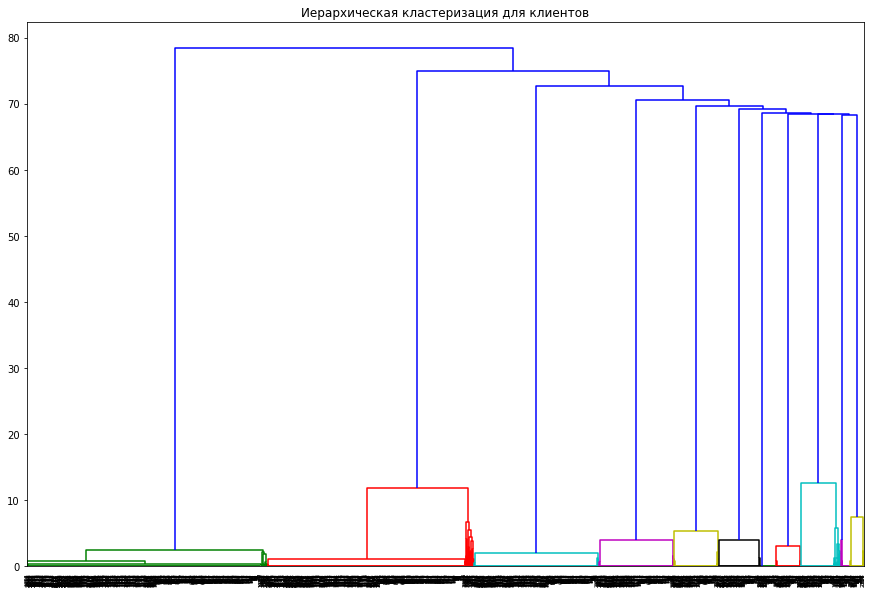

In [68]:
# рисуем дендрограмму
plt.figure(figsize=(15, 10))
dendrogram(linked_1, orientation='top')
plt.title('Иерархическая кластеризация для клиентов')
plt.show()

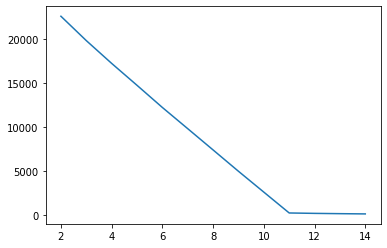

In [69]:
# определяем оптимальное кол-во кластеров методом локтя
crit_1 = []
for k in range(2, 15):
    kmeans = KMeans(n_clusters = k, random_state = 0)
    kmeans.fit(x_sc_1)
    crit_1.append(kmeans.inertia_)
crit_1
plt.plot(range(2, 15), crit_1)

In [70]:
## обучаем модель KMeans
km = KMeans(n_clusters = 11, random_state=0) # задаём число кластеров, равное 11 на основе метода локатя
labels_1 = km.fit_predict(x_sc_1) # применяем алгоритм к данным и формируем вектор кластеров

In [71]:
# сохраняем метки кластера в поле нашего датасета
client_categories_logic['cluster_km'] = labels_1
#display(client_categories_logic.head())

# группируем клиентов по кластерам, признаку оттока и средним значениям
clusters_mix = client_categories_logic.groupby(['cluster_km']).mean()
#clusters_mix = clusters_mix.reset_index()
display(clusters_mix)
display(labels_1)

category_name  белье_и_одежда     декор  крупные_емкости  напольные_покрытия  \
cluster_km                                                                     
0                    0.004167  0.956984         0.000000            0.003538   
1                    0.001980  0.003947         0.000000            0.000532   
2                    0.989550  0.000000         0.000008            0.001892   
3                    0.000892  0.000542         0.996995            0.000000   
4                    0.001955  0.000597         0.000000            0.000000   
5                    0.005446  0.000000         0.000000            0.983467   
6                    0.000000  0.000000         0.000000            0.004446   
7                    0.005193  0.000000         0.000000            0.000000   
8                    0.000000  0.000000         0.000000            0.000000   
9                    0.007936  0.000000         0.010524            0.000000   
10                   0.011412  0.000000         0.000000            0.000000   

category_name    прочее  растения  стремянки  товары_для_ванной  \
cluster_km                                                        
0              0.000000  0.031191   0.000000           0.000000   
1              0.002258  0.989197   0.000000           0.000589   
2              0.001200  0.002308   0.000000           0.001550   
3              0.000191  0.001006   0.000000           0.000000   
4              0.003632  0.002582   0.000848           0.001711   
5              0.001826  0.003869   0.000000           0.000747   
6              0.002575  0.000000   0.000000           0.992155   
7              0.990863  0.003944   0.000000           0.000000   
8              0.000000  0.000000   0.000000           0.000000   
9              0.000000  0.000000   0.963076           0.003321   
10             0.000000  0.000000   0.000000           0.002076   

category_name  товары_для_кухни  товары_для_хранения    уборка        сумма  
cluster_km                                                                   
0                      0.004121             0.000000  0.000000   385.666667  
1                      0.000624             0.000209  0.000664   729.412628  
2                      0.002542             0.000169  0.000782  1308.358792  
3                      0.000374             0.000000  0.000000  1918.936599  
4                      0.988283             0.000000  0.000392   918.747619  
5                      0.000000             0.004645  0.000000  1055.485294  
6                      0.000825             0.000000  0.000000  1200.836207  
7                      0.000000             0.000000  0.000000  1037.590164  
8                      0.000000             0.000000  1.000000  1251.333333  
9                      0.015143             0.000000  0.000000  2673.131579  
10                     0.000000             0.986512  0.000000  2811.680000

array([1, 2, 8, ..., 1, 4, 2], dtype=int32)

In [72]:
#### проверка качества кластеризации
silhouette_score(x_sc_1, labels_1)

0.9686661294611741

#### Комментарий
Проверка качества кластеризации методом силуэта около 1, т.е. разделение по кластерам достаточно точное.

Можно выделить следующие кластеры по доминирующей группе товаров в миксе выручки от клиента:
- Кластер 0 - декор
- Кластер 1 - растения
- Кластер 2 - белье_и_одежда
- Кластер 3 - крупные_емкости
- Кластер 4 - товары_для_кухни
- Кластер 5 - напольные_покрытия
- Кластер 6 - товары_для_ванной
- Кластер 7 - прочее
- Кластер 8 - уборка
- Кластер 9 - стремянки
- Кластер 10 - решения для хранения

In [73]:
# добавим метки кластеров к фрейму с параметрами клиентов
common_client_table_no_anomalies = pd.merge(common_client_table_no_anomalies, client_categories_logic[['customer_id','cluster_km']],on='customer_id', how='left')
common_client_table_no_anomalies.head()

customer_id  revenue  order_qty  avr_check  \
0  1b2764ad-9151-4051-a46a-9b01b62e6335  24370.0          1    24370.0   
1  9f1e7d7d-ff10-4eb1-b596-1cbf8075aa3f  22056.0          1    22056.0   
2  909564b8-3a5c-4d3e-8310-5ba1c837bbd7  16536.0          1    16536.0   
3  0d87f4ae-465a-4fac-81e6-5d629761783e  14917.0          1    14917.0   
4  d35ce92b-08ec-46a5-87c5-2ef42c65ed3e  10656.0          1    10656.0   

    avr_qty  product_name_qty  cluster_km  
0  5.000000                 1           7  
1  2.238095                21           2  
2  3.000000                 1           4  
3  1.000000                 1           2  
4  3.333333                 6           1

In [74]:
#присвоение названий кластерам категорий
cluster_names = pd.DataFrame([[0, 'декор'], 
                            [1,'растения'], 
                            [2,'белье_и_одежда'], 
                            [3,'крупные_емкости'],
                            [4,'товары_для_кухни'],
                            [5,'напольные_покрытия'],
                            [6,'товары_для_ванной'],
                            [7, 'прочее'],
                            [8, 'уборка'],
                            [9, 'стремянки'],                            
                            [10, 'решения_для_хранения']], columns=['cluster_km','cluster_name'])
cluster_names.head()

cluster_km      cluster_name
0           0             декор
1           1          растения
2           2    белье_и_одежда
3           3   крупные_емкости
4           4  товары_для_кухни

In [75]:
# группируем клиентов по кластерам и выводим кол-во клиентов в кластере
cluster_qty = grouping_func(common_client_table_no_anomalies,'cluster_km','customer_id', 'nunique')
cluster_qty['share'] = cluster_qty['customer_id'] / cluster_qty['customer_id'].sum()
cluster_qty = cluster_qty.merge(cluster_names, on = 'cluster_km', how = 'left')
cluster_qty['share'] = cluster_qty['share'].map('{:.0%}'.format)
display(cluster_qty)

cluster_km  customer_id share          cluster_name
0            1          681   29%              растения
1            2          563   24%        белье_и_одежда
2            3          347   15%       крупные_емкости
3            4          210    9%      товары_для_кухни
4            7          122    5%                прочее
5            6          116    5%     товары_для_ванной
6            0          108    5%                 декор
7            5           68    3%    напольные_покрытия
8            8           45    2%                уборка
9            9           38    2%             стремянки
10          10           25    1%  решения_для_хранения

In [76]:
# построим столбчатую горизонтальную диаграмму по доле клиентов в зависимости от клатера
fig_1 = px.bar(cluster_qty, x ='share', y='cluster_name', text = 'share', title='Доли клиентов по сегментам', labels=dict(cluster_name ="название сегмента", share ="доля от всех клиентов") , orientation = 'h', width=800, height=800)
# сделаем порядок сортировки колонок от большего к меньшему
fig_1.update_yaxes(autorange="reversed")
fig_1.show()

#### Комментарии
Самыми крупными кластерами по кол-ву клиентов как и ожидалось оказались растения-1, белье и одежда-2, крупные емкости-3, товары для кухни-4. Остальные значительно меньше по кол-ву клиентов и доли продуктовой категории в товарообороте магазина.

При разработке персонализированных предложений целесообразно сфокусироваться на этих 4 кластерах, т.к. они охватывают большинство клиентов и отражают лидирующие продуктовые группы в товарообороте. 

In [77]:
# группируем клиентов по кластерам и выводим среднее по их параметрам
mean_client_values = common_client_table_no_anomalies.groupby(['cluster_km']).mean()
mean_client_values_and_share_of_clients = mean_client_values.merge(cluster_qty, on = 'cluster_km', how = 'left')
mean_client_values_and_share_of_clients = mean_client_values_and_share_of_clients.sort_values(by = 'customer_id', ascending = False)
mean_client_values_and_share_of_clients

cluster_km      revenue  order_qty    avr_check   avr_qty  \
1            1   729.412628   1.110132   660.373715  1.611302   
2            2  1308.358792   1.049734  1254.404085  1.397625   
3            3  1918.936599   1.060519  1800.716138  1.151297   
4            4   918.747619   1.047619   883.730159  2.219007   
7            7  1037.590164   1.032787  1009.967213  1.781876   
6            6  1200.836207   1.068966  1126.780172  1.368103   
0            0   385.666667   1.101852   352.825617  3.318652   
5            5  1055.485294   1.044118  1032.801471  1.403186   
8            8  1251.333333   1.022222  1219.688889  1.888889   
9            9  2673.131579   1.052632  2503.447368  1.039474   
10          10  2811.680000   1.080000  2696.280000  1.893333   

    product_name_qty  customer_id share          cluster_name  
1           3.415565          681   29%              растения  
2           1.154529          563   24%        белье_и_одежда  
3           1.083573          347   15%       крупные_емкости  
4           1.276190          210    9%      товары_для_кухни  
7           1.131148          122    5%                прочее  
6           1.103448          116    5%     товары_для_ванной  
0           2.361111          108    5%                 декор  
5           1.220588           68    3%    напольные_покрытия  
8           1.000000           45    2%                уборка  
9           1.210526           38    2%             стремянки  
10          1.120000           25    1%  решения_для_хранения

#### Комментарий
Все 4 основных кластера различаются по среднему чеку. Лидер - крупные емкости. 

Видимые различия по кол-ву заказов за период незначительны, лидруют растения.

Необходимо проверить насколько статистически значимы эти различия.

### Вывод по кластеризации
1. Кластеризация проводилась на основе доли товарной категории в сумме заказа клиентов как основного параметра определяющего профиль потребления.
2. Было выделено 11 кластеров на основе метода локтя. Метод силуэта показал высокую точность.
3. В ходе анализа распределения клиентов по кластерам были выделены ТОП4 сегмента - растения, белье и одежда, крупные емоксти и товары для кухни, которые лидируют по кол-ву клиентов и обороту.

## Формулировка и проверка гипотез

**Проверка нормальности распределений:**
- Нулевая гипотеза - распределение в выборках основных кластеров нормальное

- Альтернативная гипотеза - распределение в выборках не нормальное

**Проверка различий в выборках:**


*Средний чек*
- Нулевая гипотеза - различий по среднему чеку по основным кластерам нет, выявленные различия в выборках случайны

- Альтернативная гипотеза - результаты по среднему чеку по основным кластерам в реальности с большой вероятностью отличаются

*Частота заказов*
- Нулевая гипотеза - различий по частоте заказов по основным кластерам нет, выявленные различия в выборках случайны

- Альтернативная гипотеза - результаты по частоте заказов по основным кластерам в реальности с большой вероятностью отличаются

*Среднее кол-во штук на клиента*
- Нулевая гипотеза - различий по среднему кол-ву штук на клиента по основным кластерам нет, выявленные различия в выборках случайны

- Альтернативная гипотеза - результаты по среднему кол-ву штук на клиента по основным кластерам в реальности с большой вероятностью отличаются

*Среднее кол-во уникальных позиций, купленных за период*
- Нулевая гипотеза - различий по среднему кол-ву уникальных позиций за период по основным кластерам нет, выявленные различия в выборках случайны

- Альтернативная гипотеза - результаты по среднему кол-ву уникальных позиций за период по основным кластерам в реальности с большой вероятностью отличаются


In [78]:
# разделим выборку по основным кластерам
cluster_1_check = common_client_table_no_anomalies.query('cluster_km == 1')['avr_check']
cluster_2_check = common_client_table_no_anomalies.query('cluster_km == 2')['avr_check']
cluster_3_check = common_client_table_no_anomalies.query('cluster_km == 3')['avr_check']
cluster_4_check = common_client_table_no_anomalies.query('cluster_km == 4')['avr_check']

cluster_1_orders = common_client_table_no_anomalies.query('cluster_km == 1')['order_qty']
cluster_2_orders = common_client_table_no_anomalies.query('cluster_km == 2')['order_qty']
cluster_3_orders = common_client_table_no_anomalies.query('cluster_km == 3')['order_qty']
cluster_4_orders = common_client_table_no_anomalies.query('cluster_km == 4')['order_qty']

cluster_1_avr_qty = common_client_table_no_anomalies.query('cluster_km == 1')['avr_qty']
cluster_2_avr_qty = common_client_table_no_anomalies.query('cluster_km == 2')['avr_qty']
cluster_3_avr_qty = common_client_table_no_anomalies.query('cluster_km == 3')['avr_qty']
cluster_4_avr_qty = common_client_table_no_anomalies.query('cluster_km == 4')['avr_qty']

cluster_1_product_name_qty = common_client_table_no_anomalies.query('cluster_km == 1')['product_name_qty']
cluster_2_product_name_qty = common_client_table_no_anomalies.query('cluster_km == 2')['product_name_qty']
cluster_3_product_name_qty = common_client_table_no_anomalies.query('cluster_km == 3')['product_name_qty']
cluster_4_product_name_qty = common_client_table_no_anomalies.query('cluster_km == 4')['product_name_qty']

In [79]:
#проверим выборки на нормальность распределения
def normal_control(sample):
    alpha = 0.05
    results1 = stats.shapiro(sample)
    p_value1 = results1[1]
    print('p-значение тест Шапиро-Уилка по выборке: ', p_value1)
    if p_value1 < alpha:
        print('Отвергаем нулевую гипотезу по выборке: распределение не нормально')
    else:
        print('Не получилось отвергнуть нулевую гипотезу по выборке:, всё нормально') 

In [80]:
print('проверка нормальности по среднему чеку')
normal_control(cluster_1_check)
normal_control(cluster_2_check)
normal_control(cluster_3_check)
normal_control(cluster_4_check)
print('проверка нормальности по среднему кол-ву заказов')
normal_control(cluster_1_orders)
normal_control(cluster_2_orders)
normal_control(cluster_3_orders)
normal_control(cluster_4_orders)
print('проверка нормальности по среднему кол-ву штук в заказе')
normal_control(cluster_1_avr_qty)
normal_control(cluster_2_avr_qty)
normal_control(cluster_3_avr_qty)
normal_control(cluster_4_avr_qty)
print('проверка нормальности по среднему кол-ву уникальных товаров за период')
normal_control(cluster_1_product_name_qty)
normal_control(cluster_2_product_name_qty)
normal_control(cluster_3_product_name_qty)
normal_control(cluster_4_product_name_qty)

проверка нормальности по среднему чеку
p-значение тест Шапиро-Уилка по выборке:  6.293655716457751e-38
Отвергаем нулевую гипотезу по выборке: распределение не нормально
p-значение тест Шапиро-Уилка по выборке:  3.7090330777578665e-35
Отвергаем нулевую гипотезу по выборке: распределение не нормально
p-значение тест Шапиро-Уилка по выборке:  2.0725923054246758e-21
Отвергаем нулевую гипотезу по выборке: распределение не нормально
p-значение тест Шапиро-Уилка по выборке:  5.072091137607161e-25
Отвергаем нулевую гипотезу по выборке: распределение не нормально
проверка нормальности по среднему кол-ву заказов
p-значение тест Шапиро-Уилка по выборке:  3.0828566215145976e-44
Отвергаем нулевую гипотезу по выборке: распределение не нормально
p-значение тест Шапиро-Уилка по выборке:  4.4701421011961665e-43
Отвергаем нулевую гипотезу по выборке: распределение не нормально
p-значение тест Шапиро-Уилка по выборке:  1.3120626301729107e-35
Отвергаем нулевую гипотезу по выборке: распределение не нормаль

#### Комментарий
- Распределения ненормальны, поэтому целесообразно воспользоваться непараметрическим тестом Манна-Уитни для определения сдвига и различий в данных выборок  по среднему чеку,частоте заказа, среднему кол-ву, и кол-ву уникальных позиций
- Уровень статистистической значимости alfa выбран 0.01, чтобы снизить частоту ошибочных срабатываний теста, выделить только явно проявляющиеся различия и избежать доп.расходов на проверку выявленных гипотез.

In [81]:
def mannwhitneyu_func(sample1, sample2):
    p_value = stats.mannwhitneyu(sampleA, sampleB, alternative='two-sided')[1]
    print("p-value конверсии: {0:.3f}".format(p_value))
    if p_value < alpha:
          print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

#### Комментарий
Поскольку основных выборок у нас 4 и мы проводим множественное сравнение, то целесообразно использовать поправку Бонферрони при проверке гипотезы долей.

In [94]:
# применяем поправку Бонферрони
bonferroni_alpha = 0.01 / 6
def mannwhitneyu_func(sample1, sample2):
    p_value = stats.mannwhitneyu(sample1, sample2, alternative='two-sided')[1]
    print("p-value конверсии: {0:.10f}".format(p_value))
    if p_value < bonferroni_alpha:
          print('Отвергаем нулевую гипотезу: между выборками есть значимая разница')
    else:
        print('Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными') 

In [95]:
# проверка различий в среднем чеке
print('сравним группу 1 и 2')
mannwhitneyu_func(cluster_1_check, cluster_2_check)
print('сравним группу 1 и 3')
mannwhitneyu_func(cluster_1_check, cluster_3_check)
print('сравним группу 1 и 4')
mannwhitneyu_func(cluster_1_check, cluster_4_check)
print('сравним группу 2 и 3')
mannwhitneyu_func(cluster_2_check, cluster_3_check)
print('сравним группу 2 и 4')
mannwhitneyu_func(cluster_2_check, cluster_4_check)
print('сравним группу 3 и 4')
mannwhitneyu_func(cluster_3_check, cluster_4_check)

сравним группу 1 и 2
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 3
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 4
p-value конверсии: 0.0000131237
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 2 и 3
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 2 и 4
p-value конверсии: 0.0000012448
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 3 и 4
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница


#### Комментарий
Таким образом, на основе проверки критерием Манна-Уитни при p-value < 0,0025(с поправкой Бонферрони) - нулевую гипотезу **по среднему чеку можно отвергнуть, т.е. различия, установленные в выборках, реальны с высокой степенью вероятности.**

In [96]:
# проверка различий в частоте заказов
print('сравним группу 1 и 2')
mannwhitneyu_func(cluster_1_orders, cluster_2_orders)
print('сравним группу 1 и 3')
mannwhitneyu_func(cluster_1_orders, cluster_3_orders)
print('сравним группу 1 и 4')
mannwhitneyu_func(cluster_1_orders, cluster_4_orders)
print('сравним группу 2 и 3')
mannwhitneyu_func(cluster_2_orders, cluster_3_orders)
print('сравним группу 2 и 4')
mannwhitneyu_func(cluster_2_orders, cluster_4_orders)
print('сравним группу 3 и 4')
mannwhitneyu_func(cluster_3_orders, cluster_4_orders)

сравним группу 1 и 2
p-value конверсии: 0.0042181363
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 1 и 3
p-value конверсии: 0.0171027817
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 1 и 4
p-value конверсии: 0.0232440582
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 2 и 3
p-value конверсии: 0.9911735790
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 2 и 4
p-value конверсии: 0.7010596118
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 3 и 4
p-value конверсии: 0.7296246718
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Комментарий
Таким образом, на основе проверки критерием Манна-Уитни при p-value < 0,0025(с поправкой Бонферрони) - **нулевую гипотезу по частоте заказов не отвергаем, полученные различия могут быть случайны.**

In [97]:
# проверка различий в кол-ве штук в заказах
print('сравним группу 1 и 2')
mannwhitneyu_func(cluster_1_avr_qty, cluster_2_avr_qty)
print('сравним группу 1 и 3')
mannwhitneyu_func(cluster_1_avr_qty, cluster_3_avr_qty)
print('сравним группу 1 и 4')
mannwhitneyu_func(cluster_1_avr_qty, cluster_4_avr_qty)
print('сравним группу 2 и 3')
mannwhitneyu_func(cluster_2_avr_qty, cluster_3_avr_qty)
print('сравним группу 2 и 4')
mannwhitneyu_func(cluster_2_avr_qty, cluster_4_avr_qty)
print('сравним группу 3 и 4')
mannwhitneyu_func(cluster_3_avr_qty, cluster_4_avr_qty)

сравним группу 1 и 2
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 3
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 4
p-value конверсии: 0.0003130399
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 2 и 3
p-value конверсии: 0.0001625106
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 2 и 4
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 3 и 4
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница


#### Комментарий
Таким образом, на основе проверки критерием Манна-Уитни при p-value < 0,0025(с поправкой Бонферрони) - нулевую гипотезу **по среднему кол-ву штук в заказах можно отвергнуть, т.е. различия, установленные в выборках, реальны с высокой степенью вероятности.**

In [98]:
# проверка различий в кол-ве уникальных позиций в заказах
print('сравним группу 1 и 2')
mannwhitneyu_func(cluster_1_product_name_qty, cluster_2_product_name_qty)
print('сравним группу 1 и 3')
mannwhitneyu_func(cluster_1_product_name_qty, cluster_3_product_name_qty)
print('сравним группу 1 и 4')
mannwhitneyu_func(cluster_1_product_name_qty, cluster_4_product_name_qty)
print('сравним группу 2 и 3')
mannwhitneyu_func(cluster_2_product_name_qty, cluster_3_product_name_qty)
print('сравним группу 2 и 4')
mannwhitneyu_func(cluster_2_product_name_qty, cluster_4_product_name_qty)
print('сравним группу 3 и 4')
mannwhitneyu_func(cluster_3_product_name_qty, cluster_4_product_name_qty)

сравним группу 1 и 2
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 3
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 1 и 4
p-value конверсии: 0.0000000000
Отвергаем нулевую гипотезу: между выборками есть значимая разница
сравним группу 2 и 3
p-value конверсии: 0.0732627004
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 2 и 4
p-value конверсии: 0.5789683787
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
сравним группу 3 и 4
p-value конверсии: 0.0480723170
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Комментарии
По кол-ву уникальных товарных позиций, купленных за период выявлены различия между растениями и тремя другими основными категориями, различия же между этими категориями подтверждены не были.

In [87]:
mean_client_values_and_share_of_clients = mean_client_values_and_share_of_clients.drop(['order_qty', 'revenue', 'customer_id'], axis = 1)
mean_client_values_and_share_of_clients.columns = ['кластер', 'средний чек', 'среднее кол-во в заказе', 'среднее кол-во уникальных позиций за период', 'доля клиентов в кластере', 'имя кластера']
mean_client_values_and_share_of_clients

кластер  средний чек  среднее кол-во в заказе  \
1         1   660.373715                 1.611302   
2         2  1254.404085                 1.397625   
3         3  1800.716138                 1.151297   
4         4   883.730159                 2.219007   
7         7  1009.967213                 1.781876   
6         6  1126.780172                 1.368103   
0         0   352.825617                 3.318652   
5         5  1032.801471                 1.403186   
8         8  1219.688889                 1.888889   
9         9  2503.447368                 1.039474   
10       10  2696.280000                 1.893333   

    среднее кол-во уникальных позиций за период доля клиентов в кластере  \
1                                      3.415565                      29%   
2                                      1.154529                      24%   
3                                      1.083573                      15%   
4                                      1.276190                       9%   
7                                      1.131148                       5%   
6                                      1.103448                       5%   
0                                      2.361111                       5%   
5                                      1.220588                       3%   
8                                      1.000000                       2%   
9                                      1.210526                       2%   
10                                     1.120000                       1%   

            имя кластера  
1               растения  
2         белье_и_одежда  
3        крупные_емкости  
4       товары_для_кухни  
7                 прочее  
6      товары_для_ванной  
0                  декор  
5     напольные_покрытия  
8                 уборка  
9              стремянки  
10  решения_для_хранения

### Вывод по гипотезам
В результате проверки гипотез были выявлены различия между всему кластерами с (p-value < 0,0025(с поправкой Бонферрони)) в среднем чеке и среднем кол-ве штук на клиента, а также различия между кластером растений и тремя остальными кластерами в кол-ве уникальных товарных позиций, заказываемых клиентами.

## Выводы и рекомендации

### Резюме по подготовке данных

В ходе подготовки данных:
- пропусков обнаружено не было
- данные по дате в стандартный формат datetime
- удалены полные дубликаты, которые различались лишь часом заказа. **Необходима проверка аномалии со стороны дата-инженеров**
- также удалены полные дубликаты отличавшиеся только датами в рамках одного заказа
- был выявлен период анализируемого датасета - с 01.10.2018 по 31.10.2019
- отсечены как выбросы 5% на основе аномальной частоты и кол-ва штук в заказах

### Результаты исследования

#### Клиенты
- 93% клиентов совершили всего 1 заказ за период
- 86% клиентов совершают заказ в среднем с 1 позицией
- 82% клиентов купили более 1 товарной позиции за период
- 72% клиентов покупают товары в кол-ве 1 штуки

**Таким образом, установлено, что большинство клиентов розничные, покупают 1 раз и за период не возвращаются, т.е. по ним нет истории потребления, и покупают один конкретный товар.**

В связи с этим был проведен анализ в разрезе продуктов.

##### Продукты
В рамках анализа заказов были выделены 11 продуктовых групп:
- Растения
- Декор и искусственные растения
- Белье и одежда
- Крупные емкости (тазы, тележки, ведра)
- Товары для кухни
- Товары для ванной
- Товары для уборки
- Товары для хранения
- Напольные покрытия
- Стремянки
- Прочее

ТОП-4 группы по обороту на которые приходятся ок.80% оборота:
- Белье и одежда (27%)
- Крупные емкости (25%)
- Растения (18%)
- Товары для кухни (7%)

3 группы с наименьшей долей в обороте:
- Декор (1%)
- Уборка (2%)
- Решения для хранения(3%)

#### Сегментация
Клиенты были сегментированы на основе доли продуктовой группы в их обороте на 11 кластеров согласно продуктовым группам.

80% клиентов оказались в следующих группах:
- Растения(29%)
- Белье и одежда(24%)
- Крупные емкости (15%)
- Товары для кухни (9%)


В ходе исследования была подтверждена статистическая значимость различий в среднем чеке, среднем кол-ве штук на клиента (с alpha 0.0025) между этими сегментами, а также различия между растениями и остальными тремя сегментами в кол-ве уникальных товаров, купленных за период.

#### Рекомендации

На данном этапе в условиях почти полного отсутствия повторных покупок, узкого диапазона интересующих товаров для большинства клиентов можно сконцентрироваться на категориях, охватывающих основную часть клиентов:
- растения
- белье и одежда
- крупные емкости
- товары для кухни

По этим категориям целесообразно сформировать персонализированные предложения. Остальные категории охватывают меньшую часть клиентов и генерируют меньше товарооборота, поэтому приоритет можно поставить ниже.

Например:
1. клиентам приобретающим растения делать персонализированные подборки с рассадой к дачному сезону, а не в сезон предлагать комнатные растения. Таким образом можно поднять retention, т.к. как было выявлено у любителей растений одним растением дело обычно не ограничивается.
2. клиентам приобретающим растения предлагать товары из смежных категорий - например, сумки-тележки (крупные емкости). Для клиентов пенсионного возраста может быть интересно.